In [58]:
import os
import re
import sys

import itertools
import textwrap

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

import scanpy as sc
import gseapy as gp

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
import seaborn as sns

import pytorch_lightning as pl
pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import calculate_DxC_gene_effect, select_important_genes_for_factor_IQR, calculate_DxC_effect, assign_D_to_celltype
from src.analysis.plotting import make_gp_dotplot, plot_gene_loadings_for_factor, visualize_DxC_effect

Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")

if "age_scaled" not in adata.obs.columns:
    age_scaled = StandardScaler().fit_transform(adata.obs.age.to_numpy().reshape(-1,1))
    age_scaled = pd.DataFrame(age_scaled, index=adata.obs.index, columns=["age_scaled"])
    adata.obs = adata.obs.merge(age_scaled, left_index=True, right_index=True)

adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1', 'age_scaled'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downre

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)

adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)

In [4]:
# adata.var.to_csv("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K_adata-var.tsv", sep="\t", header=True, index=True)

In [5]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effectorT  cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [6]:
adata.uns["cell_label_colors"] = [cell_label_colors[ct] for ct in adata.obs.cell_label.cat.categories]

In [7]:
background_genes = adata.var.GeneSymbol

# databases_bio = ["GO_Biological_Process_2023", "Elsevier_Pathway_Collection",  "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 
databases_bio = ["GO_Biological_Process_2023", "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 

In [8]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [9]:
sc.settings.figdir = os.path.join(model_results_dir, "Figures")

In [10]:
cell_state = pd.read_csv(os.path.join(model_results_dir,
                                    f"{model}_cell-state_latent.tsv"),
                               sep="\t", index_col=0)

In [11]:
umap_cc = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_latent_UMAP.tsv"),
    sep="\t", index_col=0
)

In [12]:
adata.obsm["X_umap"] = umap_cc.loc[adata.obs.index].to_numpy()

In [13]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix.columns = assignment_matrix.columns.str.replace("U_", "D_")
assignment_matrix.head()

,D_Factor1,D_Factor2,D_Factor3,D_Factor4,D_Factor5,D_Factor6,D_Factor7,D_Factor8,D_Factor9,D_Factor10,...,D_Factor691,D_Factor692,D_Factor693,D_Factor694,D_Factor695,D_Factor696,D_Factor697,D_Factor698,D_Factor699,D_Factor700
Cell-state_Factor1,8.437773e-07,7.903217e-08,0.000149,2.960464e-08,0.105288,9.999727e-01,5.675518e-07,0.958925,0.000287,0.000158,...,5.023212e-06,4.209568e-06,1.000000e+00,4.168299e-03,9.999992e-01,0.209136,0.078419,6.167789e-07,0.018491,0.140772
Cell-state_Factor2,1.292795e-06,6.067657e-08,0.000136,6.915393e-08,0.105908,1.794856e-02,5.106163e-07,0.115423,0.026317,0.000138,...,1.773568e-07,6.894123e-06,7.097198e-02,2.241115e-07,8.517019e-07,0.047724,0.001983,7.762388e-07,0.000035,0.041986
Cell-state_Factor3,9.953613e-07,6.230532e-08,0.000141,1.447328e-06,0.000004,4.638549e-07,9.892867e-01,0.965989,0.000585,0.000156,...,2.023449e-07,2.216382e-06,5.867200e-05,5.172464e-03,6.707507e-07,0.132809,0.001249,1.094831e-06,0.938939,0.154773
Cell-state_Factor4,6.680752e-07,6.124807e-02,0.000136,3.778137e-08,0.011434,4.063994e-07,9.991040e-01,0.019197,0.008096,0.000136,...,2.121831e-07,3.456871e-07,4.101363e-08,3.866343e-07,6.646220e-07,0.102437,0.012960,7.976132e-07,0.000011,0.032869
Cell-state_Factor5,4.728630e-06,2.615931e-08,0.000146,6.789284e-04,0.123782,2.302163e-07,5.004259e-07,1.000000,0.305943,0.000152,...,8.162028e-08,3.348259e-02,3.075602e-08,2.127417e-07,4.462411e-07,0.080859,0.288426,5.094969e-07,0.029717,0.271452


In [14]:
D = pd.read_csv(os.path.join(model_results_dir,
                            f"{model}_U_embedding.tsv"),
                               sep="\t", index_col=0)
D.columns = D.columns.str.replace("U", "D")
D.head()

,D_Factor1,D_Factor2,D_Factor3,D_Factor4,D_Factor5,D_Factor6,D_Factor7,D_Factor8,D_Factor9,D_Factor10,...,D_Factor691,D_Factor692,D_Factor693,D_Factor694,D_Factor695,D_Factor696,D_Factor697,D_Factor698,D_Factor699,D_Factor700
individual,,,,,,,,,,,,,,,,,,,,,
691_692,-1.042473,-3.014132,1.014801,1.139763,-0.087979,-0.651705,0.490216,-0.437837,-0.698968,-0.075018,...,-1.559727,-2.399024,-0.448335,-0.562907,1.627759,0.417358,-0.134628,0.011702,-0.679321,0.457391
693_694,0.204075,-1.975144,-0.909941,-3.882647,-2.031409,-1.043576,-0.600040,0.700274,-1.798226,1.284830,...,-4.333742,-0.440545,3.113877,-1.716786,-1.533546,0.933507,1.020350,0.339764,-1.053410,0.119764
688_689,-0.265995,-0.624907,-0.622831,-2.176815,0.853737,-0.117719,0.055314,0.302469,0.608836,-1.786304,...,-0.670751,-1.207303,8.913930,-0.353388,-0.325745,-1.125641,0.403694,-0.928585,0.525144,-0.484701
683_684,0.416159,-2.862958,-0.515983,1.572177,0.868042,-0.119366,-0.109651,0.556453,1.886532,-1.681124,...,-2.243293,-1.778274,0.387456,0.630929,-0.590417,0.165828,-2.937147,0.222008,-0.201923,0.057328
684_685,-1.244226,-4.169203,-0.287462,-0.519455,3.750650,-1.336222,0.230874,-0.624908,1.064494,0.636243,...,0.699778,-3.021685,-0.273128,-0.655736,-0.635290,0.228497,1.079147,-1.051518,0.797644,0.003049


In [15]:
DxC_decoder = pd.read_csv(os.path.join(model_results_dir,
                                            f"{model}_GxC_decoder.tsv"),
                               sep="\t", index_col=0)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

,DxC_Factor1,DxC_Factor2,DxC_Factor3,DxC_Factor4,DxC_Factor5,DxC_Factor6,DxC_Factor7,DxC_Factor8,DxC_Factor9,DxC_Factor10,...,DxC_Factor691,DxC_Factor692,DxC_Factor693,DxC_Factor694,DxC_Factor695,DxC_Factor696,DxC_Factor697,DxC_Factor698,DxC_Factor699,DxC_Factor700
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000257019,0.000003,-0.000156,0.000261,-0.000105,0.000109,-0.000148,0.000145,0.000002,0.000106,-0.000083,...,-0.000125,-0.000088,0.000062,-0.000037,-0.000043,-0.000013,-0.000199,-0.000141,0.000042,0.000049
ENSG00000166987,-0.000101,-0.000302,0.000002,-0.000025,0.000096,-0.000122,0.000290,-0.000218,-0.000033,0.000128,...,-0.000093,-0.000059,-0.000712,0.000007,-0.000217,0.000056,0.000027,0.000117,-0.000141,0.000014
ENSG00000170624,-0.000007,-0.000096,-0.000228,0.000753,-0.000033,-0.000042,-0.000032,0.001457,0.000291,-0.000079,...,-0.000690,0.000181,-0.004836,0.000014,-0.000040,0.000021,0.000080,0.000070,-0.000669,-0.000014
ENSG00000140519,0.000013,-0.000071,0.000062,-0.000007,-0.000070,0.000082,-0.000036,0.000126,-0.000059,-0.000021,...,0.000164,0.000251,-0.000099,0.000035,-0.000080,-0.000019,-0.000139,0.000042,-0.000011,-0.000129
ENSG00000117115,-0.000463,-0.000236,0.000113,-0.000527,0.000036,0.000147,-0.000130,-0.000716,-0.000064,0.000002,...,0.000046,0.000210,0.000123,-0.000185,-0.000235,0.000060,-0.000145,0.000712,-0.000128,-0.000025


In [16]:
PRS = pd.read_csv("/data/danai/Data/OneK1K/PRS_standard-scaled.tsv", sep="\t", index_col=0).T
PRS = PRS.loc[D.index]
PRS

,T2D,Lymphocyte_percentage,Height,Monocyte_percentage,Celiac,Platelet_count,RA,PDW,RBC,Endometriosis,...,Leukocyte_count,Psoriasis,Plateletcrit,Monocyte_count,MCV,Myopia,T1D,UC,RBDW,IBD
individual,,,,,,,,,,,,,,,,,,,,,
691_692,1.255989,0.073441,-0.038045,1.057455,-0.126709,0.684278,-1.158741,0.291028,-0.251568,0.183071,...,1.168590,2.725448,0.479527,0.807803,0.462384,-1.799243,-0.340664,-0.338635,-2.590094,0.921506
693_694,-0.445195,0.026328,-1.346833,0.200311,-0.875266,-0.073953,0.459058,0.509122,1.521804,0.306532,...,0.880476,0.432755,0.449513,0.275580,0.058884,0.310888,-0.112788,-0.743467,-0.007997,0.014525
688_689,0.921082,-0.574450,0.035532,2.242845,0.986089,-0.044611,-0.277833,0.747621,1.307181,-1.115088,...,1.319138,1.101461,0.630030,2.244478,0.250202,-0.594614,-0.108329,-2.242711,-0.096182,1.185607
683_684,-0.695708,0.895006,-1.820075,-0.982672,0.849274,0.493378,1.479542,-1.056867,-0.344106,-1.368122,...,0.281813,-0.152931,-0.209626,-0.346156,-0.393779,-0.475122,1.789246,-0.326834,0.221220,-0.037600
684_685,0.033624,-1.099108,-0.191696,1.049505,-0.315700,-0.548276,-1.441501,0.694509,0.662240,-0.253174,...,0.370617,-0.516708,1.225127,1.023994,-0.605399,1.161970,-1.034379,0.741925,2.396896,2.401865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840_841,0.856233,-0.253691,0.214005,0.554112,-0.068020,-0.238728,0.974408,1.211065,1.173662,-0.628667,...,0.761485,1.516462,0.626888,0.515276,-0.142372,1.543327,0.439937,-0.419462,0.017823,-0.124476
801_802,-0.114730,0.555844,-0.315786,0.234048,-0.036434,-0.015106,-0.948971,2.162178,-0.315019,-0.508913,...,-0.172859,-0.490349,0.287179,0.780339,-0.383261,-0.811570,-0.877014,0.098815,-1.273162,1.414959
797_798,0.731864,-0.075157,-0.176929,1.792253,-0.738498,1.443055,0.671065,-0.879431,-0.393431,-0.484769,...,-1.030489,0.088861,0.224763,0.823324,0.695126,-1.260892,-0.046859,1.745476,-1.562931,0.858955


## Single-gene testing

In [29]:
prs_single_gene = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_gene-level-testing-results_tensorQTL_PRS_significant_BH_005.tsv", sep="\t")
prs_single_gene 

,PRS,gene,p_value,effect_size,effect_size_se,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue
0,RA,ENSG00000237541,9.695591e-10,0.538064,0.087115,CD4-ET,6.574692e-05,6.574692e-05,1.058272e-03
1,Multiple_sclerosis,ENSG00000206503,2.467539e-15,-0.145157,0.018034,CD4-ET,3.151968e-10,3.151968e-10,5.073453e-09
2,Psoriasis,ENSG00000234745,2.132760e-27,0.255924,0.022870,CD4-ET,7.809746e-22,7.809746e-22,1.257068e-20
3,Psoriasis,ENSG00000204525,4.412189e-07,0.110659,0.021759,CD4-ET,2.163826e-02,2.163826e-02,3.482926e-01
4,T1D,ENSG00000116198,1.042748e-06,-0.356039,0.072433,CD4-ET,4.545638e-02,4.545638e-02,7.316726e-01
...,...,...,...,...,...,...,...,...,...
123,Multiple_sclerosis,ENSG00000237541,1.138665e-06,-0.505952,0.103139,Plasma,4.886209e-02,4.886209e-02,7.864915e-01
124,Psoriasis,ENSG00000234745,9.135416e-09,0.164066,0.028236,Plasma,5.702061e-04,5.702061e-04,9.178121e-03
125,T1D,ENSG00000237541,1.073929e-16,0.861978,0.101536,Plasma,1.474693e-11,1.474693e-11,2.373687e-10
126,Psoriasis,ENSG00000234745,2.628227e-09,0.187778,0.031192,CD4-SOX4,1.739286e-04,1.739286e-04,2.799580e-03


In [36]:
adata.var.reset_index(names="gene").filter(["gene","GeneSymbol"])

,gene,GeneSymbol
0,ENSG00000257019,OR13C2
1,ENSG00000166987,MBD6
2,ENSG00000170624,SGCD
3,ENSG00000140519,RHCG
4,ENSG00000117115,PADI2
...,...,...
14207,ENSG00000185811,IKZF1
14208,ENSG00000234465,PINLYP
14209,ENSG00000170615,SLC26A5
14210,ENSG00000151778,SERP2


In [37]:
prs_single_gene = prs_single_gene.merge(adata.var.reset_index(names="gene").filter(["gene","GeneSymbol"]), on="gene", how="left")
prs_single_gene.head()

,PRS,gene,p_value,effect_size,effect_size_se,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue,GeneSymbol
0,RA,ENSG00000237541,9.695591e-10,0.538064,0.087115,CD4-ET,6.574692e-05,6.574692e-05,1.058272e-03,HLA-DQA2
1,Multiple_sclerosis,ENSG00000206503,2.467539e-15,-0.145157,0.018034,CD4-ET,3.151968e-10,3.151968e-10,5.073453e-09,HLA-A
2,Psoriasis,ENSG00000234745,2.132760e-27,0.255924,0.022870,CD4-ET,7.809746e-22,7.809746e-22,1.257068e-20,HLA-B
3,Psoriasis,ENSG00000204525,4.412189e-07,0.110659,0.021759,CD4-ET,2.163826e-02,2.163826e-02,3.482926e-01,HLA-C
4,T1D,ENSG00000116198,1.042748e-06,-0.356039,0.072433,CD4-ET,4.545638e-02,4.545638e-02,7.316726e-01,CEP104


In [38]:
prs_single_gene.loc[prs_single_gene.PRS == "RA"]

,PRS,gene,p_value,effect_size,effect_size_se,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue,GeneSymbol
0,RA,ENSG00000237541,9.695591e-10,0.538064,0.087115,CD4-ET,6.574692e-05,6.574692e-05,1.058272e-03,HLA-DQA2
6,RA,ENSG00000196735,1.166233e-20,0.526064,0.055150,NK,2.372508e-15,2.372508e-15,3.818824e-14,HLA-DQA1
7,RA,ENSG00000237541,5.665507e-48,1.219178,0.079149,NK,3.111895e-41,3.111895e-41,5.008952e-40,HLA-DQA2
16,RA,ENSG00000196735,2.661722e-12,0.264000,0.037251,CD4-NC,2.564921e-07,2.564921e-07,4.128535e-06,HLA-DQA1
17,RA,ENSG00000237541,4.050251e-28,0.852937,0.075109,CD4-NC,1.711295e-22,1.711295e-22,2.754525e-21,HLA-DQA2
26,RA,ENSG00000237541,1.091954e-20,0.845939,0.088613,CD8-S100B,2.306839e-15,2.306839e-15,3.713122e-14,HLA-DQA2
32,RA,ENSG00000196735,8.754150e-33,0.389369,0.031432,CD8-ET,8.013992e-27,8.013992e-27,1.289944e-25,HLA-DQA1
33,RA,ENSG00000237541,5.277646e-41,0.895102,0.063607,CD8-ET,9.662849e-35,9.662849e-35,1.555346e-33,HLA-DQA2
48,RA,ENSG00000237541,1.941371e-12,0.364210,0.051060,B-IN,1.904175e-07,1.904175e-07,3.064988e-06,HLA-DQA2
49,RA,ENSG00000198502,1.390480e-19,-0.161108,0.017410,B-IN,2.386717e-14,2.386717e-14,3.841695e-13,HLA-DRB5


In [39]:
prs_single_gene.loc[(prs_single_gene.GeneSymbol == "HLA-DQA2") & (prs_single_gene.celltype == "NK")]

,PRS,gene,p_value,effect_size,effect_size_se,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue,GeneSymbol
7,RA,ENSG00000237541,5.665507e-48,1.219178,0.079149,NK,3.111895e-41,3.111895e-41,5.008952e-40,HLA-DQA2
11,Multiple_sclerosis,ENSG00000237541,1.180216e-09,-0.523855,0.085262,NK,7.905584e-05,7.905584e-05,1.272494e-03,HLA-DQA2
14,T1D,ENSG00000237541,1.501903e-14,0.674162,0.086318,NK,1.755215e-09,1.755215e-09,2.825219e-08,HLA-DQA2


In [40]:
prs_single_gene.PRS.nunique()

13

In [41]:
prs_single_gene.PRS.unique()

array(['RA', 'Multiple_sclerosis', 'Psoriasis', 'T1D', 'Celiac',
       'Hair_color', 'Platelet_count', 'PDW', 'UC', 'RBDW', 'T2D',
       'Monocyte_percentage', 'IBD'], dtype=object)

In [42]:
prs_single_gene.loc[prs_single_gene.PRS == "Hair_color"]

,PRS,gene,p_value,effect_size,effect_size_se,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue,GeneSymbol
8,Hair_color,ENSG00000117010,2.684146e-07,0.402548,0.077687,NK,0.013526,0.013526,0.217715,ZNF684
50,Hair_color,ENSG00000126106,1.066398e-07,0.514207,0.096004,B-IN,0.005578,0.005578,0.089792,TMEM53


# LIVI results

In [17]:
PRS_effects = pd.read_csv(os.path.join(model_results_dir, "PRS_LMM_results_BH-0.05_Ucontext.tsv"),
                          sep="\t")
PRS_effects.Factor = PRS_effects.Factor.str.replace("U_", "D_")
PRS_effects

,Factor,SNP_id,effect_size,effect_size_se,p_value,corrected_pvalue
0,D_Factor19,Celiac,-0.163174,0.024693,2.334779e-11,2.150454e-08
1,D_Factor19,RA,0.124845,0.023360,7.291072e-08,4.556920e-05
2,D_Factor36,Psoriasis,0.232348,0.038465,1.075110e-09,8.180186e-07
3,D_Factor41,Celiac,0.190772,0.026913,6.878921e-13,7.523819e-10
4,D_Factor41,RA,-0.273531,0.025460,1.545146e-28,5.408012e-25
...,...,...,...,...,...,...
61,D_Factor682,Multiple_sclerosis,-0.102831,0.021557,1.600630e-06,7.570549e-04
62,D_Factor682,T1D,0.113796,0.021492,9.646476e-08,5.821149e-05
63,D_Factor687,Celiac,-0.261583,0.043401,1.171553e-09,8.542575e-07
64,D_Factor687,Multiple_sclerosis,0.169433,0.041612,4.331119e-05,1.486168e-02


In [18]:
PRS_effects.SNP_id = PRS_effects.SNP_id.replace({"Celiac": "CeD", "Multiple_sclerosis":"MS"})

In [235]:
PRS_effects.rename(columns={"SNP_id":"PRS"}).to_csv(
    os.path.join(model_results_dir, "PRS-associations_all_BH-0.05_Paper-suppl.tsv"),
    sep="\t", index=False, header=True
)

In [19]:
PRS_effects = PRS_effects.assign(fPRS = PRS_effects.SNP_id + "__" + PRS_effects.Factor)
PRS_effects

,Factor,SNP_id,effect_size,effect_size_se,p_value,corrected_pvalue,fPRS
0,D_Factor19,CeD,-0.163174,0.024693,2.334779e-11,2.150454e-08,CeD__D_Factor19
1,D_Factor19,RA,0.124845,0.023360,7.291072e-08,4.556920e-05,RA__D_Factor19
2,D_Factor36,Psoriasis,0.232348,0.038465,1.075110e-09,8.180186e-07,Psoriasis__D_Factor36
3,D_Factor41,CeD,0.190772,0.026913,6.878921e-13,7.523819e-10,CeD__D_Factor41
4,D_Factor41,RA,-0.273531,0.025460,1.545146e-28,5.408012e-25,RA__D_Factor41
...,...,...,...,...,...,...,...
61,D_Factor682,MS,-0.102831,0.021557,1.600630e-06,7.570549e-04,MS__D_Factor682
62,D_Factor682,T1D,0.113796,0.021492,9.646476e-08,5.821149e-05,T1D__D_Factor682
63,D_Factor687,CeD,-0.261583,0.043401,1.171553e-09,8.542575e-07,CeD__D_Factor687
64,D_Factor687,MS,0.169433,0.041612,4.331119e-05,1.486168e-02,MS__D_Factor687


In [20]:
PRS_effects.SNP_id.nunique()

10

In [21]:
PRS_effects.SNP_id.unique()

array(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'Lymphocyte_count', 'UC',
       'RBC', 'RBDW', 'T2D'], dtype=object)

In [22]:
PRS_effects.Factor.nunique()

37

In [23]:
PRS_effects.groupby("SNP_id").apply(lambda x: x.Factor.nunique())

/tmp/ipykernel_1797050/1030827017.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


SNP_id
CeD                 18
Lymphocyte_count     1
MS                  14
Psoriasis           11
RA                   9
RBC                  1
RBDW                 2
T1D                  7
T2D                  1
UC                   2
dtype: int64

In [24]:
PRS_effects.loc[PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])].Factor.nunique()

32

In [25]:
for f in PRS_effects.loc[PRS_effects.SNP_id.isin(["Lymphocyte_count", "RBC", "RBDW"])].Factor.unique():
    print(f in PRS_effects.loc[PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])].Factor.unique().tolist())

False
False
False
False


In [78]:
## Focus on autoimmune diseases
PRS_effects = PRS_effects.loc[PRS_effects.SNP_id.isin(["IBD", "CeD", "UC", "T1D", "MS", "Psoriasis", "RA"])]
PRS_effects.SNP_id.unique()

array(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'], dtype=object)

In [79]:
PRS_colors = dict(
    zip(["CeD", "MS", "Psoriasis", "RA", "T1D", "UC"],
        sns.color_palette("Set2", 6))
)
PRS_colors 

{'CeD': (0.4, 0.7607843137254902, 0.6470588235294118),
 'MS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'Psoriasis': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'RA': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'T1D': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 'UC': (1.0, 0.8509803921568627, 0.1843137254901961)}

In [80]:
PRS_colors_dark = dict(
    zip(["CeD", "MS", "Psoriasis", "RA", "T1D", "UC"],
        ["peru", "royalblue", "slateblue", "darkred", "darkgreen", "mediumseagreen"])
) 

In [81]:
PRS_effects.groupby("SNP_id").apply(lambda x: x.Factor.nunique())

/tmp/ipykernel_1797050/1030827017.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


SNP_id
CeD          18
MS           14
Psoriasis    11
RA            9
T1D           7
UC            2
dtype: int64

In [82]:
PRS_effects.nlargest(3, columns="effect_size", keep="all")

,Factor,SNP_id,effect_size,effect_size_se,p_value,corrected_pvalue,fPRS,Celltype
16,D_Factor293,RA,0.429920,0.033767,2.003210e-40,1.168539e-36,RA__D_Factor293,B Mem
10,D_Factor126,Psoriasis,0.370971,0.041848,1.425287e-19,2.494253e-16,Psoriasis__D_Factor126,None
7,D_Factor72,CeD,0.337784,0.031566,2.603542e-28,7.593664e-25,CeD__D_Factor72,NK


In [83]:
PRS_effects.nsmallest(3, columns="effect_size", keep="all")

,Factor,SNP_id,effect_size,effect_size_se,p_value,corrected_pvalue,fPRS,Celltype
38,D_Factor454,RA,-0.448254,0.022657,1.232558e-110,2.156976e-106,RA__D_Factor454,NK
8,D_Factor72,RA,-0.434800,0.029862,6.977421e-54,6.105243e-50,RA__D_Factor72,NK
53,D_Factor661,Psoriasis,-0.361534,0.039125,3.339088e-21,7.304256e-18,Psoriasis__D_Factor661,Mono C


### Scatterplot of PRS vs. factor

In [49]:
tmp = D.filter(PRS_effects.Factor)
tmp = tmp.merge(PRS, right_index=True, left_index=True, how="left")
tmp.head()

,D_Factor19,D_Factor36,D_Factor41,D_Factor69,D_Factor72,D_Factor126,D_Factor144,D_Factor147,D_Factor210,D_Factor223,...,Leukocyte_count,Psoriasis,Plateletcrit,Monocyte_count,MCV,Myopia,T1D,UC,RBDW,IBD
individual,,,,,,,,,,,,,,,,,,,,,
691_692,0.123229,0.705303,1.854355,-0.324754,1.797535,1.440416,-0.234058,0.037699,-4.273785,1.128427,...,1.168590,2.725448,0.479527,0.807803,0.462384,-1.799243,-0.340664,-0.338635,-2.590094,0.921506
693_694,2.047674,-1.734437,-0.180548,0.041680,-0.769870,2.011178,-0.090131,-0.362218,0.569802,-0.681610,...,0.880476,0.432755,0.449513,0.275580,0.058884,0.310888,-0.112788,-0.743467,-0.007997,0.014525
688_689,0.984981,-0.688939,1.634096,-1.553127,1.994873,-0.403126,-0.512309,-0.243749,2.270372,0.222401,...,1.319138,1.101461,0.630030,2.244478,0.250202,-0.594614,-0.108329,-2.242711,-0.096182,1.185607
683_684,0.059177,1.016745,-0.101119,0.254557,-0.135661,0.492243,-0.816543,2.851629,-0.613692,-0.739146,...,0.281813,-0.152931,-0.209626,-0.346156,-0.393779,-0.475122,1.789246,-0.326834,0.221220,-0.037600
684_685,-1.115713,-0.700316,0.166186,-0.040473,1.347377,-0.216282,-0.182701,0.844044,-0.421337,1.483429,...,0.370617,-0.516708,1.225127,1.023994,-0.605399,1.161970,-1.034379,0.741925,2.396896,2.401865


In [50]:
tmp = tmp.merge(adata.obs.filter(["individual", "sex", "latent"]).drop_duplicates().set_index("individual"), right_index=True, left_index=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


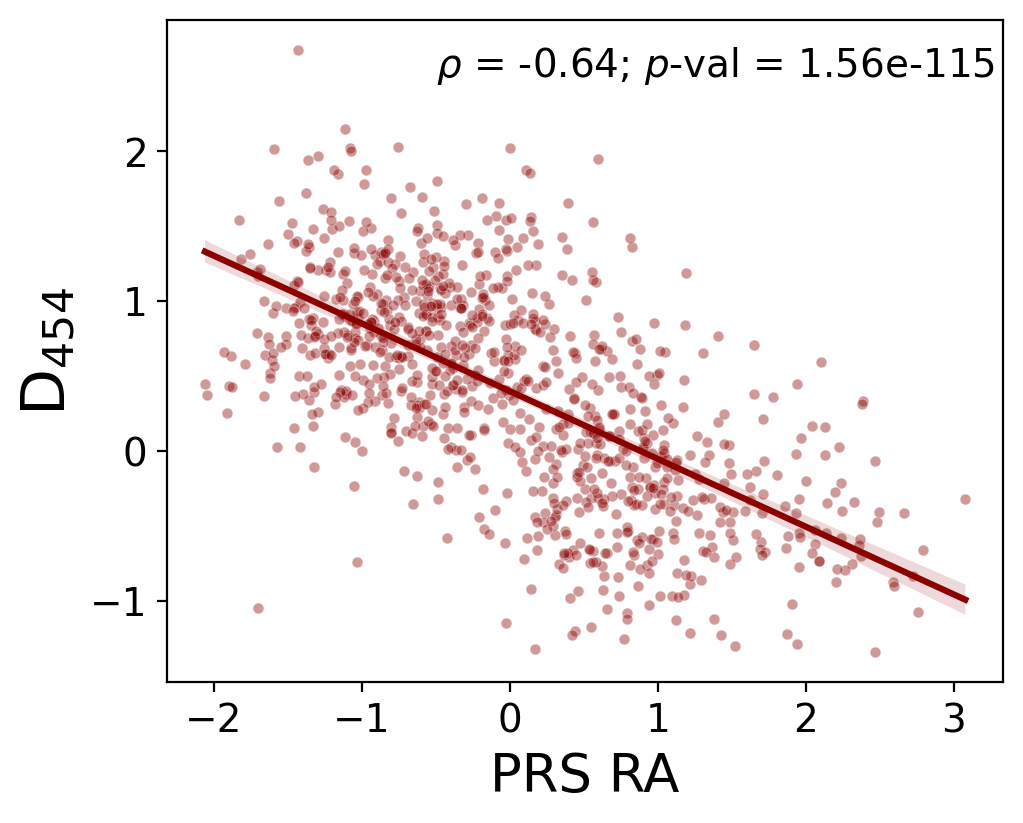

In [109]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5,4), constrained_layout=True)

sns.scatterplot(x="RA", y="D_Factor454", data=tmp, color=PRS_colors_dark["RA"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="RA", y="D_Factor454", data=tmp, color=PRS_colors_dark["RA"], ax=axs, scatter=False)
axs.set_xlabel("PRS RA", fontsize=19)
axs.set_ylabel("D$_{454}$", fontsize=22)
corr, pval = spearmanr(tmp["RA"], tmp["D_Factor454"])
axs.text(x=-0.5, y=2.5, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
            fontdict={"color":"black", "fontsize":14, "ma":"right"})
# axs.text(x=0.87, y=2.15, s=f"$p$-val = {pval:.2e}",
#            fontdict={"color":"black", "fontsize":14, "ma":"right"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA_vs_D454_v2.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA_vs_D454_v2.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA_vs_D454_v2.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


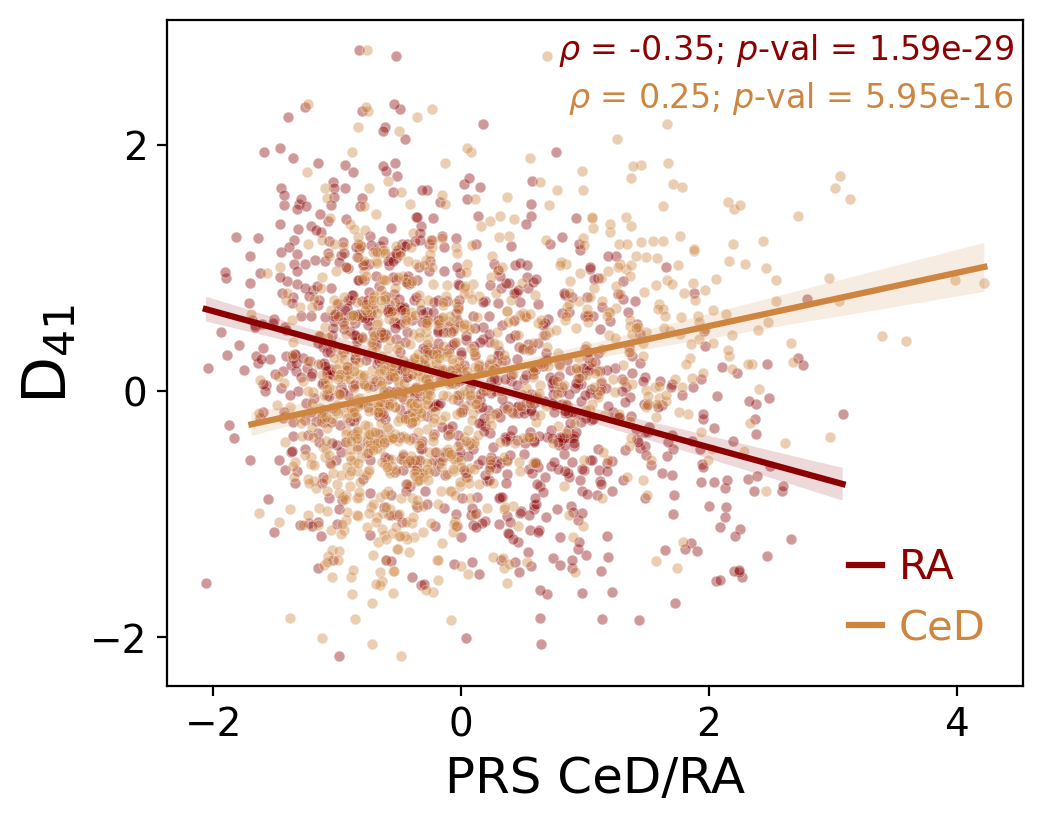

In [120]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5.1,4), constrained_layout=True)

sns.scatterplot(x="RA", y="D_Factor41", data=tmp, color=PRS_colors_dark["RA"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="RA", y="D_Factor41", data=tmp, color=PRS_colors_dark["RA"], ax=axs, scatter=False, label="RA")

sns.scatterplot(x="Celiac", y="D_Factor41", data=tmp, color=PRS_colors_dark["CeD"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="Celiac", y="D_Factor41", data=tmp, color=PRS_colors_dark["CeD"], ax=axs, scatter=False, label="CeD")


ymin = axs.get_yticks().min()
ymax = axs.get_yticks().max()
xmin = axs.get_xticks().min()
xmax = axs.get_xticks().max()

axs.set_ylabel("D$_{41}$", fontsize=22)
axs.set_yticks(
    np.arange(ymin, ymax, 2) 
    if 0 in np.arange(ymin, ymax, 2) 
    else np.arange(ymin+1, ymax, 2)
)
axs.set_xlabel("PRS CeD/RA", fontsize=18)
axs.set_xticks(np.arange(xmin+2, xmax, 2))
corr, pval = spearmanr(tmp["RA"], tmp["D_Factor41"])
axs.text(x=0.78, y=2.69, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
             fontdict={"color":PRS_colors_dark["RA"], "fontsize":12, "ma":"right"})
corr, pval = spearmanr(tmp["Celiac"], tmp["D_Factor41"])
axs.text(x=0.86, y=2.3, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
             fontdict={"color":PRS_colors_dark["CeD"], "fontsize":12, "ma":"right"})

axs.legend(frameon=False, handlelength=0.8, markerscale=30, fontsize=15, labelcolor=[PRS_colors_dark["RA"], PRS_colors_dark["CeD"]])

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD-and-RA_vs_D41.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD-and-RA_vs_D41.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD-and-RA_vs_D41.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

## Plot effect on cells

### RA

In [52]:
RA_EFFECT = calculate_DxC_effect(
    DxC_associations = PRS_effects,
    SNP_id = "RA",
    cell_state_latent = cell_state,
    A = assignment_matrix,
)
RA_EFFECT

,DxC_Factor19,DxC_Factor41,DxC_Factor72,DxC_Factor210,DxC_Factor293,DxC_Factor454,DxC_Factor484,DxC_Factor634,DxC_Factor663
barcode,,,,,,,,,
AAACCTGAGAATGTTG-1,0.008688,-0.009469,-0.016501,0.003045,0.042808,-0.092857,0.026172,-0.004238,-0.007137
AAACCTGAGAGAACAG-1,0.004344,-0.019590,-0.144816,0.002388,0.056571,-0.197980,0.038494,-0.003324,-0.003844
AAACCTGAGCATGGCA-1,0.016133,-0.029437,-0.013218,0.007551,0.060962,-0.069529,0.035760,-0.010511,-0.012272
AAACCTGAGTATTGGA-1,0.005437,-0.031379,-0.048998,0.003840,0.061362,-0.110755,0.033116,-0.005345,-0.003687
AAACCTGAGTGTCCCG-1,0.005089,-0.017873,-0.053903,0.003081,0.097321,-0.095859,0.049210,-0.004289,-0.004222
...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCTGTT-9,0.042738,-0.096624,-0.016959,0.045416,0.155537,-0.072373,0.027282,-0.063220,-0.018441
TTTGTCATCCGTTGTC-9,0.014256,-0.033545,-0.019150,0.012610,0.074815,-0.054385,0.030152,-0.017554,-0.007746
TTTGTCATCGCCGTGA-9,0.008496,-0.021884,-0.024525,0.007635,0.051723,-0.055166,0.014658,-0.010628,-0.005078


In [53]:
RA_EFFECT_ct = RA_EFFECT.merge(adata.obs.cell_label, right_index=True, left_index=True)
RA_EFFECT_ct = RA_EFFECT_ct.groupby("cell_label", observed=False).apply(lambda x: x.mean(axis=0))
RA_EFFECT_ct

,DxC_Factor19,DxC_Factor41,DxC_Factor72,DxC_Factor210,DxC_Factor293,DxC_Factor454,DxC_Factor484,DxC_Factor634,DxC_Factor663
cell_label,,,,,,,,,
B IN,0.048535,-0.108368,-0.023512,0.047844,0.173803,-0.077959,0.023584,-0.066599,-0.022992
B Mem,0.046808,-0.098371,-0.017493,0.044096,0.174180,-0.069314,0.028790,-0.061382,-0.023342
CD4 ET,0.010591,-0.023436,-0.019800,0.005081,0.050928,-0.079323,0.029804,-0.007073,-0.008241
CD4 NC,0.010358,-0.022950,-0.019348,0.005519,0.052093,-0.074960,0.029453,-0.007682,-0.007837
CD4 SOX4,0.011049,-0.027496,-0.022502,0.005373,0.050742,-0.080045,0.029285,-0.007480,-0.008605
CD8 ET,0.009326,-0.021520,-0.068259,0.004475,0.094805,-0.133930,0.056195,-0.006229,-0.007363
CD8 NC,0.010184,-0.024892,-0.020106,0.004639,0.057384,-0.084875,0.033021,-0.006457,-0.008085
CD8 S100B,0.008991,-0.025601,-0.033001,0.003848,0.061719,-0.104821,0.032382,-0.005356,-0.007277
DC,0.019134,-0.075649,-0.043039,0.012519,0.121864,-0.121262,0.019816,-0.017426,-0.015813


#### DxC454

In [135]:
effect_on_genes = calculate_DxC_gene_effect(
    DxC_associations = PRS_effects,
    SNP_id = "RA",
    cell_state_latent = cell_state,
    A = assignment_matrix,
    DxC_decoder = DxC_decoder.loc[DxC_decoder["DxC_Factor454"].abs().nlargest(5).index],
    factor_id = "D_Factor454"
)
effect_on_genes = effect_on_genes.merge(adata.obs.cell_label, right_index=True, left_index=True)
effect_on_genes.head()

,ENSG00000237541,ENSG00000196126,ENSG00000204482,ENSG00000197746,ENSG00000019582,cell_label
barcode,,,,,,
AAACCTGAGAATGTTG-1,0.071921,-0.002557,0.001088,0.001069,0.000940,CD4 ET
AAACCTGAGAGAACAG-1,0.153344,-0.005451,0.002320,0.002278,0.002004,NK
AAACCTGAGCATGGCA-1,0.053853,-0.001914,0.000815,0.000800,0.000704,CD4 NC
AAACCTGAGTATTGGA-1,0.085785,-0.003050,0.001298,0.001275,0.001121,CD8 S100B
AAACCTGAGTGTCCCG-1,0.074246,-0.002639,0.001123,0.001103,0.000970,CD8 ET


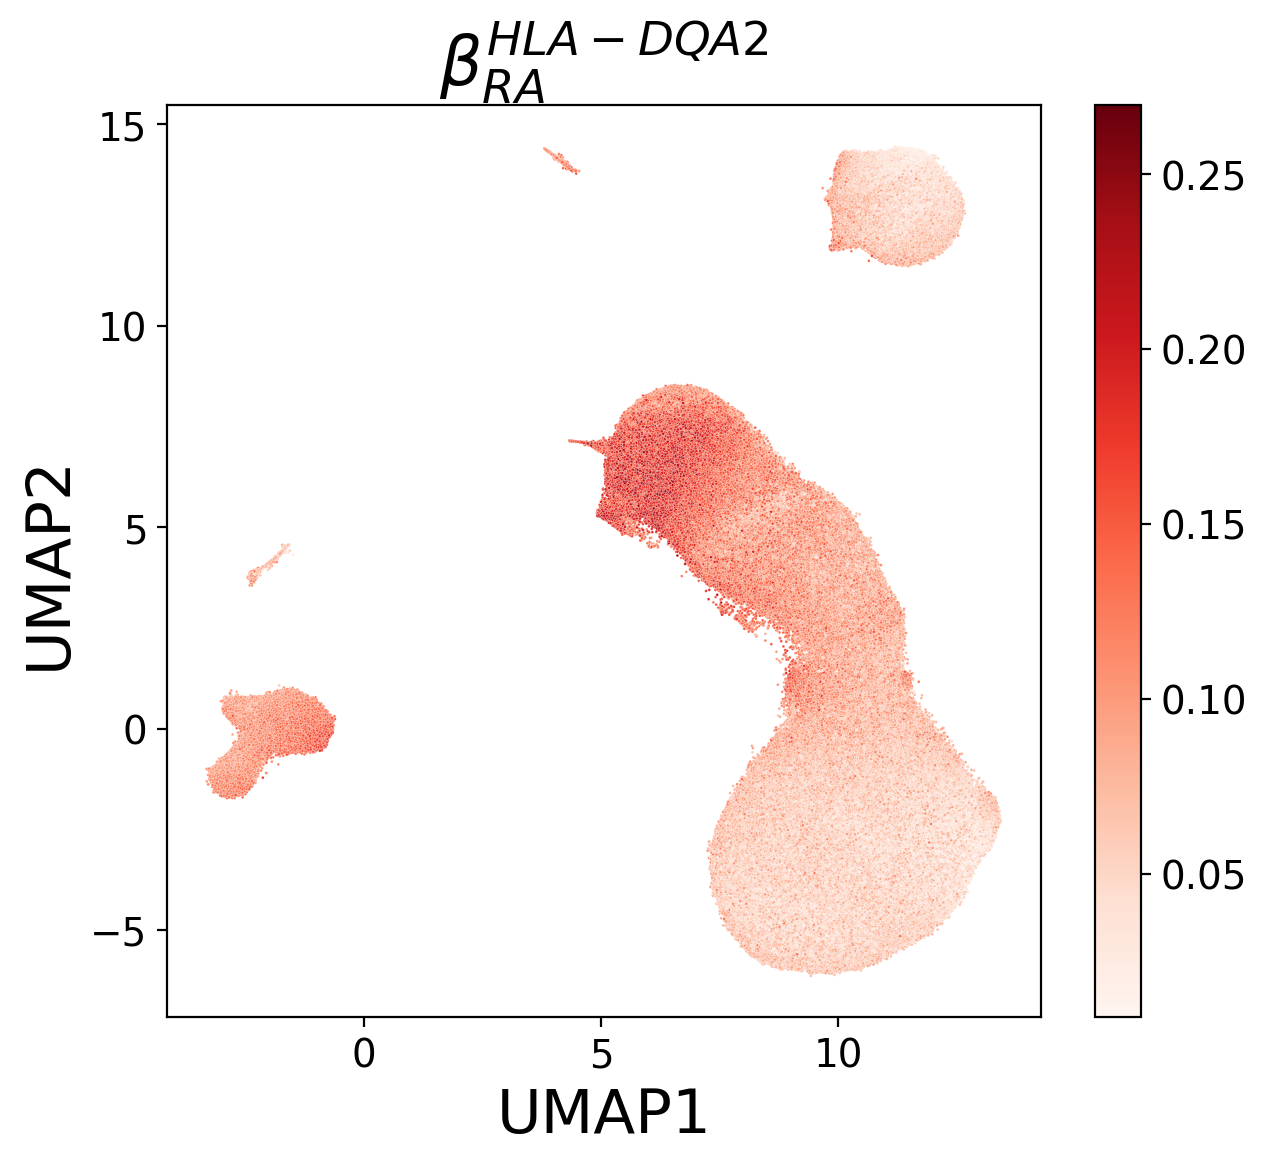

In [60]:
for g in DxC_decoder["DxC_Factor454"].abs().nlargest(1).index:

    hgnc_name = adata.var.loc[g].GeneSymbol
    if effect_on_genes[g].min() < 0 and effect_on_genes[g].max() > 0:
        comap = "RdBu_r" 
    elif effect_on_genes[g].min() < 0 and effect_on_genes[g].max() < 0:
        comap = "Blues_r"
    else:
        comap="Reds"
    
    fig, axs = plt.subplots(figsize=(7,6))
    sns.scatterplot(
        x="UMAP1",
        y="UMAP2",
        hue=g,
        data=umap_cc.merge(effect_on_genes[g], right_index=True, left_index=True),
        ax=axs,
        s=1,
        palette=comap,
        rasterized=True,
        legend=False,
    )

    Norm = (colors.TwoSlopeNorm(vcenter=0.0, vmin=effect_on_genes[g].min(), vmax=effect_on_genes[g].max()) 
            if comap == "RdBu_r"
            else colors.Normalize(vmin=effect_on_genes[g].min(), vmax=effect_on_genes[g].max()))
    sm = cm.ScalarMappable(cmap=comap, norm=Norm)
    cb = plt.colorbar(sm, ax=axs)
    
    # axs.set_title(
    #     label=f"PRS RA effect on ${hgnc_name}$", fontdict={"fontsize": 22}, loc="center"
    # )
    axs.set_title(
        label=rf"$\beta^{{{hgnc_name}}}_{{RA}}$", fontdict={"fontsize": 24}, loc="center"
    )
    axs.set_xlabel("UMAP1", fontsize=22)
    axs.set_ylabel("UMAP2", fontsize=22)
    
    plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-{hgnc_name}_D454.png"),
                             dpi=500, transparent=True, bbox_inches="tight")
    plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-{hgnc_name}_D454.eps"),
                             dpi=500, transparent=True, bbox_inches="tight")
    plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-{hgnc_name}_D454.pdf"),
                             dpi=800, transparent=True, bbox_inches="tight")

In [136]:
effect_on_HLADQA2_ct = effect_on_genes["ENSG00000237541"].to_frame()
effect_on_HLADQA2_ct = effect_on_HLADQA2_ct.merge(adata.obs.cell_label, right_index=True, left_index=True)
effect_on_HLADQA2_ct = effect_on_HLADQA2_ct.groupby("cell_label").apply(lambda x: x.mean())
effect_on_HLADQA2_ct 

/tmp/ipykernel_1261514/983465097.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,ENSG00000237541
cell_label,
B IN,0.060382
B Mem,0.053686
CD4 ET,0.061439
CD4 NC,0.058059
CD4 SOX4,0.061998
CD8 ET,0.103734
CD8 NC,0.065739
CD8 S100B,0.081188
DC,0.093923


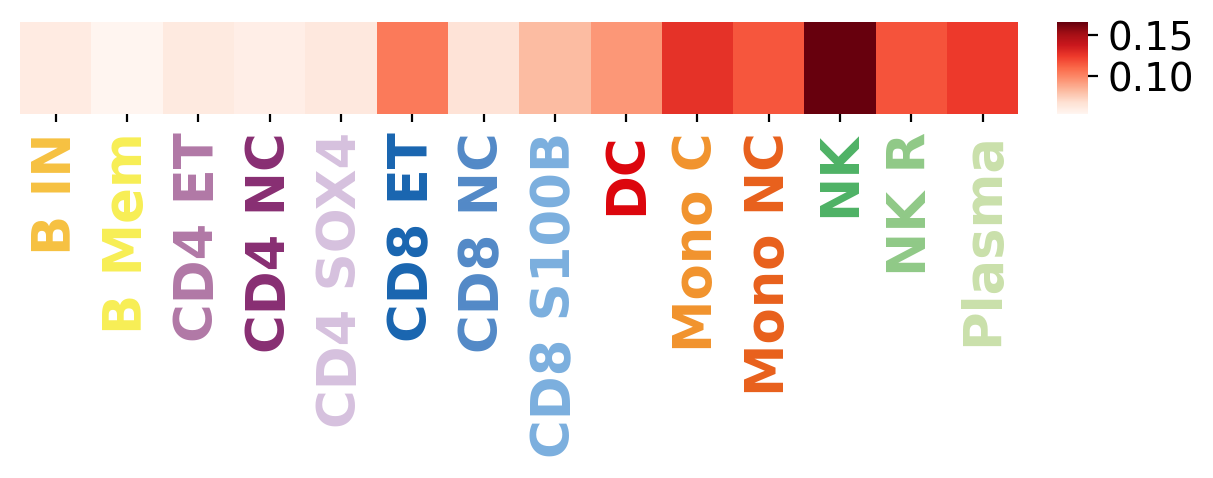

In [137]:
fig, axs = plt.subplots(figsize=(8,0.6))

sns.heatmap(effect_on_HLADQA2_ct.T, cmap="Reds", ax=axs, yticklabels=[], cbar_kws={"anchor":(-0.15,0.5), "aspect":3})
# axs.set_ylabel(fr"$GxC693_{{\beta_{{{rsid}}}}}$")
axs.set_xlabel("")
axs.xaxis.label.set_fontsize(23)
axs.tick_params(axis="x", length=3)
for j, label in enumerate(axs.get_xticklabels()):
    label.set_color(cell_label_colors[label.get_text()])
    label.set_fontweight("bold")
    label.set_fontsize(19)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_RA-effect-on-HLA-DQA2_celltype_heatmap.pdf"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_RA-effect-on-HLA-DQA2_celltype_heatmap.png"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_RA-effect-on-HLA-DQA2_celltype_heatmap.eps"), 
            bbox_inches="tight", transparent=True, dpi=600)


### CeD

In [139]:
CeD_EFFECT = calculate_DxC_effect(
    DxC_associations = PRS_effects,
    SNP_id = "CeD",
    cell_state_latent = cell_state,
    A = assignment_matrix,
)
CeD_EFFECT

,DxC_Factor19,DxC_Factor41,DxC_Factor69,DxC_Factor72,DxC_Factor210,DxC_Factor308,DxC_Factor325,DxC_Factor377,DxC_Factor395,DxC_Factor450,DxC_Factor454,DxC_Factor484,DxC_Factor503,DxC_Factor598,DxC_Factor661,DxC_Factor663,DxC_Factor682,DxC_Factor687
barcode,,,,,,,,,,,,,,,,,,
AAACCTGAGAATGTTG-1,-0.011355,0.006604,-0.071969,0.012819,-0.003018,-0.012643,-0.011641,-0.004014,0.003186,0.011058,0.027949,-0.017763,-0.004194,-0.058777,0.005187,-0.007828,0.012451,-0.003962
AAACCTGAGAGAACAG-1,-0.005678,0.013663,-0.067772,0.112503,-0.002367,-0.006998,-0.011182,-0.022196,0.002512,0.015857,0.059591,-0.026126,-0.011406,-0.068938,0.007678,-0.004216,0.011187,-0.010743
AAACCTGAGCATGGCA-1,-0.021086,0.020530,-0.031973,0.010269,-0.007484,-0.020199,-0.015446,-0.004662,0.007893,0.017014,0.020928,-0.024271,-0.016029,-0.044901,0.004795,-0.013459,0.015383,-0.005533
AAACCTGAGTATTGGA-1,-0.007106,0.021885,-0.051356,0.038065,-0.003806,-0.011616,-0.013657,-0.008295,0.004018,0.013022,0.033337,-0.022476,-0.006054,-0.054250,0.004712,-0.004044,0.013681,-0.005310
AAACCTGAGTGTCCCG-1,-0.006652,0.012465,-0.044297,0.041876,-0.003054,-0.008590,-0.010371,-0.012437,0.003237,0.009310,0.028853,-0.033399,-0.009232,-0.057263,0.008423,-0.004631,0.010455,-0.011831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCTGTT-9,-0.055859,0.067390,-0.041760,0.013175,-0.045014,-0.116557,-0.042327,-0.004698,0.047425,0.022047,0.021784,-0.018517,-0.048085,-0.028560,0.007773,-0.020225,0.051065,-0.004711
TTTGTCATCCGTTGTC-9,-0.018633,0.023396,-0.053740,0.014877,-0.012499,-0.033589,-0.016811,-0.004955,0.013175,0.017361,0.016370,-0.020464,-0.016894,-0.059495,0.005283,-0.008496,0.018993,-0.005066
TTTGTCATCGCCGTGA-9,-0.011105,0.015263,-0.050822,0.019053,-0.007567,-0.020786,-0.013284,-0.009692,0.007991,0.022072,0.016605,-0.009948,-0.009194,-0.068871,0.008960,-0.005569,0.014729,-0.011526


In [140]:
CeD_EFFECT_ct = CeD_EFFECT.merge(adata.obs.cell_label, right_index=True, left_index=True)
CeD_EFFECT_ct = CeD_EFFECT_ct.groupby("cell_label", observed=True).apply(lambda x: x.mean(axis=0))
CeD_EFFECT_ct

,DxC_Factor19,DxC_Factor41,DxC_Factor69,DxC_Factor72,DxC_Factor210,DxC_Factor308,DxC_Factor325,DxC_Factor377,DxC_Factor395,DxC_Factor450,DxC_Factor454,DxC_Factor484,DxC_Factor503,DxC_Factor598,DxC_Factor661,DxC_Factor663,DxC_Factor682,DxC_Factor687
cell_label,,,,,,,,,,,,,,,,,,
B IN,-0.063436,0.075580,-0.025528,0.018266,-0.047421,-0.118655,-0.044797,-0.007431,0.049966,0.025505,0.023465,-0.016007,-0.049146,-0.032244,0.008403,-0.025216,0.052619,-0.008030
B Mem,-0.061179,0.068608,-0.028866,0.013590,-0.043706,-0.109870,-0.044008,-0.007710,0.046056,0.023127,0.020863,-0.019540,-0.044796,-0.035087,0.009512,-0.025599,0.051409,-0.009717
CD4 ET,-0.013842,0.016346,-0.049731,0.015382,-0.005036,-0.014368,-0.016104,-0.006907,0.005318,0.015525,0.023876,-0.020228,-0.008991,-0.055301,0.006419,-0.009038,0.016744,-0.007921
CD4 NC,-0.013538,0.016006,-0.045339,0.015031,-0.005470,-0.015497,-0.015514,-0.007195,0.005776,0.018210,0.022563,-0.019990,-0.010072,-0.057612,0.006792,-0.008595,0.016266,-0.008477
CD4 SOX4,-0.014441,0.019177,-0.040329,0.017481,-0.005326,-0.014851,-0.016841,-0.007798,0.005625,0.019442,0.024093,-0.019876,-0.009976,-0.055203,0.006853,-0.009438,0.017233,-0.008818
CD8 ET,-0.012189,0.015009,-0.047356,0.053028,-0.004435,-0.012824,-0.016147,-0.011693,0.004686,0.011183,0.040312,-0.038140,-0.010120,-0.056877,0.006266,-0.008075,0.016974,-0.007940
CD8 NC,-0.013310,0.017361,-0.039915,0.015620,-0.004598,-0.013158,-0.014702,-0.006773,0.004856,0.016296,0.025547,-0.022412,-0.009624,-0.051990,0.006193,-0.008866,0.014829,-0.007799
CD8 S100B,-0.011752,0.017856,-0.042858,0.025638,-0.003814,-0.011183,-0.012680,-0.007717,0.004029,0.013667,0.031551,-0.021978,-0.007929,-0.050282,0.005735,-0.007981,0.012280,-0.007188
DC,-0.025009,0.052761,-0.029242,0.033435,-0.012408,-0.033407,-0.043774,-0.040268,0.013169,0.018016,0.036499,-0.013449,-0.014684,-0.025931,0.039390,-0.017343,0.044122,-0.057311


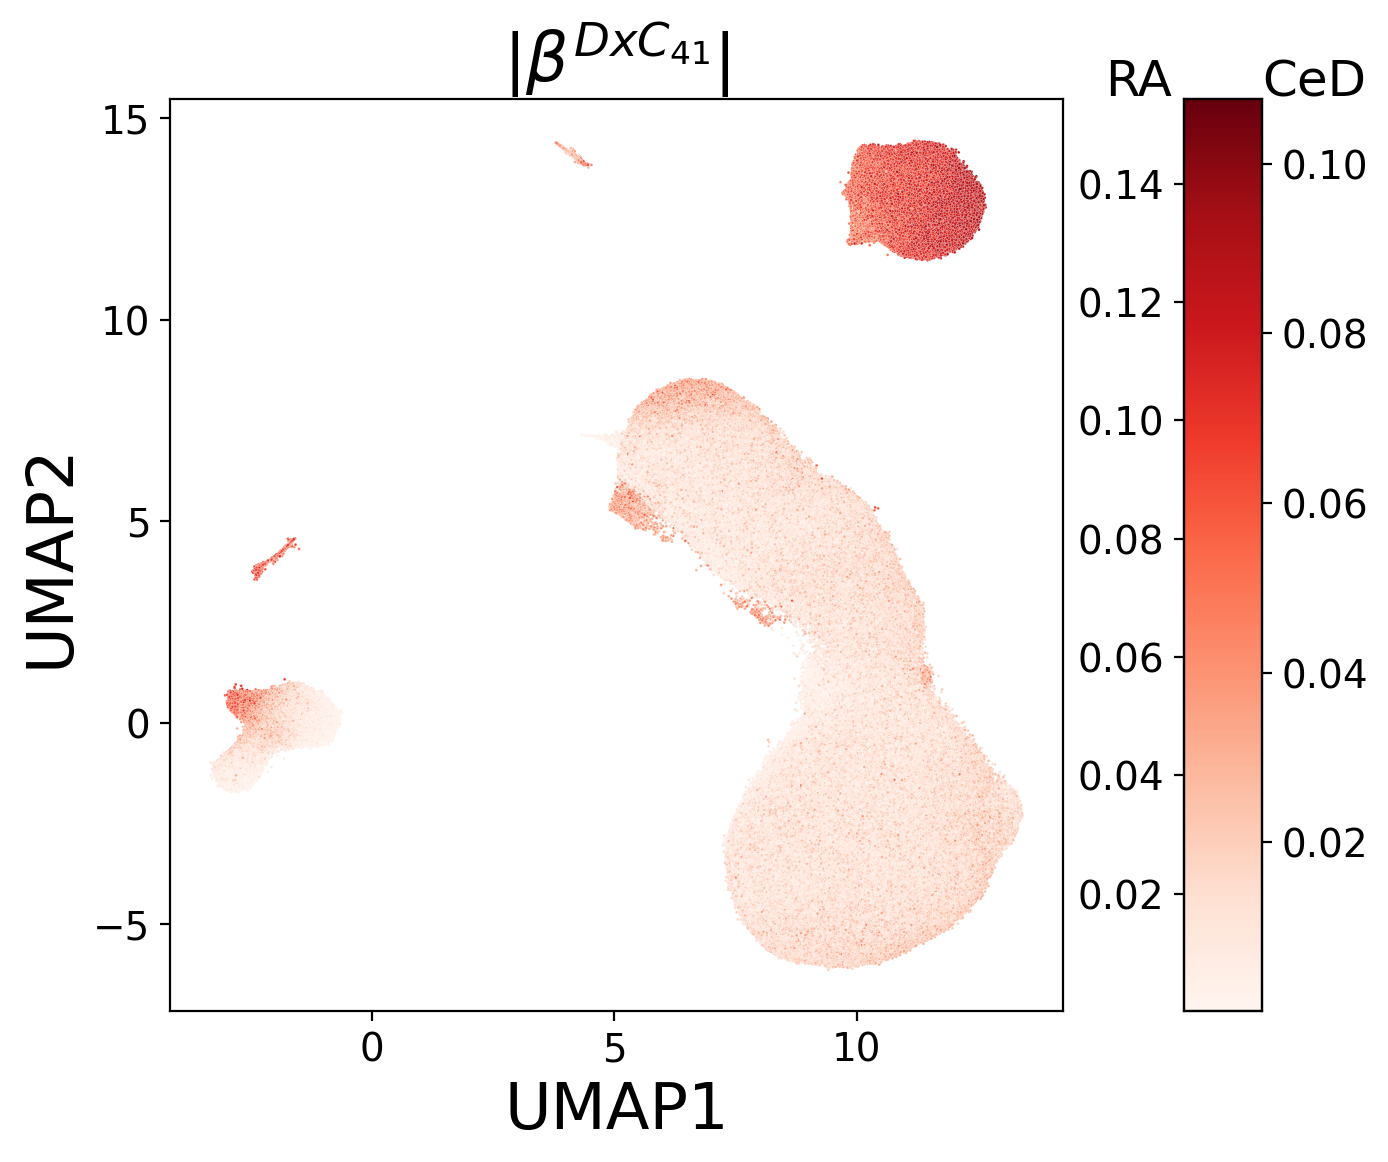

In [141]:
## Plot the effect of both RA and CeD

comap="Reds"
norM = colors.Normalize(vmin=RA_EFFECT["DxC_Factor41"].abs().min(), vmax=RA_EFFECT["DxC_Factor41"].abs().max())

fig, axs = plt.subplots(figsize=(7,6))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="DxC_Factor41",
    data=umap_cc.merge(RA_EFFECT.abs(), right_index=True, left_index=True),
    ax=axs,
    s=1,
    palette=comap,
    rasterized=True,
    legend=False,
    hue_norm=norM
)

sm = cm.ScalarMappable(
    cmap=comap,
    norm=norM
)
cb = plt.colorbar(sm, ax=axs, pad=0.032)
pos = cb.ax.get_position()
cb.ax.set_aspect("auto")
axs2 = cb.ax.twinx()
axs2.set_ylim([CeD_EFFECT["DxC_Factor41"].abs().min(), CeD_EFFECT["DxC_Factor41"].abs().max()])

# Resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.061
cb.ax.set_position(pos)
axs2.set_position(pos)

axs2.text(x=pos.x0-1.9, y=0.108, s="RA", fontdict={"fontsize": 18})

axs2.text(x=pos.x0+0.1, y=0.108, s="CeD", fontdict={"fontsize": 18})


axs.set_xlabel("UMAP1", fontsize=23)
axs.set_ylabel("UMAP2", fontsize=23)

axs.set_title(
    label=r"$|\beta^{DxC_{41}}|$", fontdict={"fontsize": 24}, loc="center"
)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_absolute-RA-and-CeD-effect-on-cells_GxC41_double-colorbar_Reds-cmap.png"),
            dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_absolute-RA-and-CeD-effect-on-cells_GxC41_double-colorbar_Reds-cmap.eps"),
            dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_absolute-RA-and-CeD-effect-on-cells_GxC41_double-colorbar_Reds-cmap.pdf"),
            dpi=500, transparent=True, bbox_inches="tight")

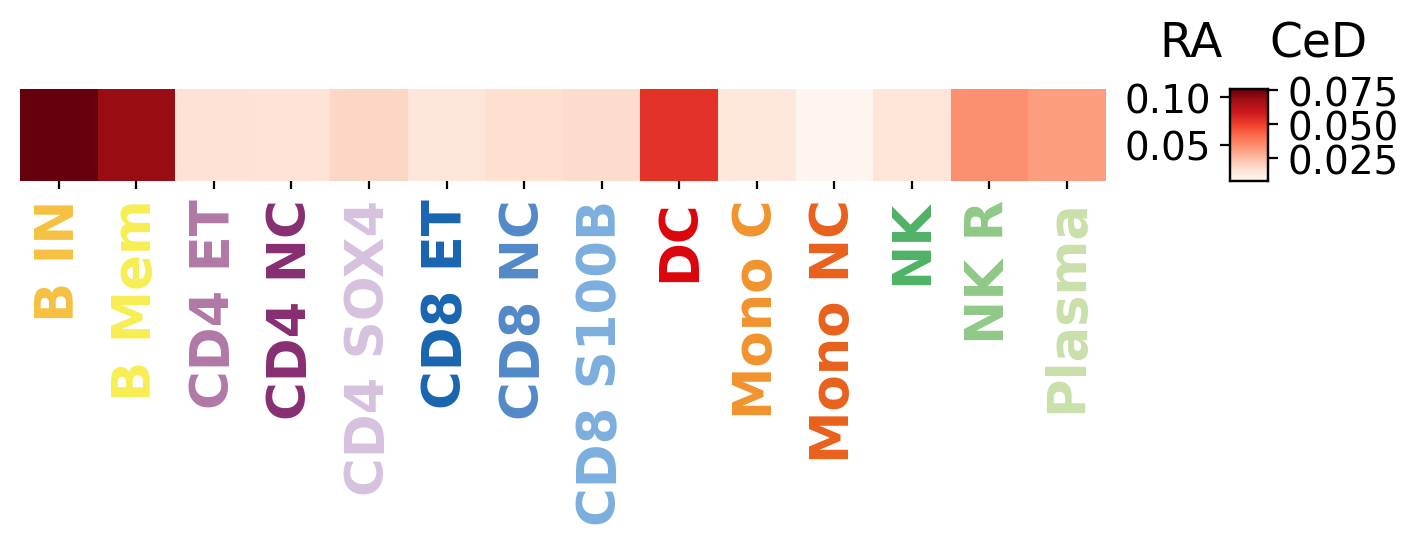

In [52]:
fig, axs = plt.subplots(figsize=(8,0.6))

norM = colors.Normalize(vmin=RA_EFFECT_ct["GxC_Factor41"].abs().min(), vmax=RA_EFFECT_ct["GxC_Factor41"].abs().max())

sns.heatmap(RA_EFFECT_ct["GxC_Factor41"].abs().to_frame().T, cmap="Reds", ax=axs, yticklabels=[],
            cbar_kws={"anchor":(-0.15,0.5)}, cbar=False)

sm = cm.ScalarMappable(
    cmap=comap,
    norm=norM
)
cb = plt.colorbar(sm, ax=axs, pad=0.01, shrink=1, fraction=0.12)
pos = cb.ax.get_position()
cb.ax.set_aspect("auto")
axs2 = cb.ax.twinx()
axs2.set_ylim([CeD_EFFECT_ct["GxC_Factor41"].abs().min(), CeD_EFFECT_ct["GxC_Factor41"].abs().max()])

# Resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.07
cb.ax.set_position(pos)
axs2.set_position(pos)

axs2.text(x=pos.x0-2.8, y=0.1, s="RA", fontdict={"fontsize": 17})

axs2.text(x=pos.x0+0.1, y=0.1, s="CeD", fontdict={"fontsize": 17})


axs.set_xlabel("")
axs.xaxis.label.set_fontsize(23)
axs.tick_params(axis="x", length=3)
for j, label in enumerate(axs.get_xticklabels()):
    label.set_color(cell_label_colors[label.get_text()])
    label.set_fontweight("bold")
    label.set_fontsize(19)

# # add border for visual clarity
# for spine in axs.spines.values():
#     spine.set_visible(True)
#     spine.set_edgecolor("#ededed")
#     spine.set_linewidth(1)
    
plt.savefig(os.path.join(model_results_dir, "Figures", "GxC41_absolute-effect-RA-and-CeD_celltype_heatmap_Reds-cmap.pdf"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "GxC41_absolute-effect-RA-and-CeD_celltype_heatmap_Reds-cmap.png"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "GxC41_absolute-effect-RA-and-CeD_celltype_heatmap_Reds-cmap.eps"), 
            bbox_inches="tight", transparent=True, dpi=600)


## Assign effects to celltypes

In [84]:
D_celltype = assign_D_to_celltype(
    cell_state_latent=cell_state,
    A=assignment_matrix,
    cell_metadata=adata.obs,
    celltype_column="cell_label",
    top_one=True,
    assignment_threshold=0.9
)

In [85]:
PRS_effects = PRS_effects.assign(Celltype = PRS_effects.apply(lambda x: D_celltype[x.Factor], axis=1))
PRS_effects = PRS_effects.explode("Celltype")
PRS_effects.head()

,Factor,SNP_id,effect_size,effect_size_se,p_value,corrected_pvalue,fPRS,Celltype
0,D_Factor19,CeD,-0.163174,0.024693,2.334779e-11,2.150454e-08,CeD__D_Factor19,Plasma
1,D_Factor19,RA,0.124845,0.023360,7.291072e-08,4.556920e-05,RA__D_Factor19,Plasma
2,D_Factor36,Psoriasis,0.232348,0.038465,1.075110e-09,8.180186e-07,Psoriasis__D_Factor36,CD8 ET
3,D_Factor41,CeD,0.190772,0.026913,6.878921e-13,7.523819e-10,CeD__D_Factor41,B IN
4,D_Factor41,RA,-0.273531,0.025460,1.545146e-28,5.408012e-25,RA__D_Factor41,B IN


## GSEA

### Find top genes for PRS-associated factors

In [165]:
prs_gene_ct = []
# Focus on autoimmune diseases
for prs in PRS_effects.SNP_id.unique():
    prs_topgene = []
    prs_ct = []
    prs_factor = []
    for idx, row in PRS_effects.loc[PRS_effects.SNP_id == prs].iterrows():
        topgenes = select_important_genes_for_factor_IQR(
            genes_factors_loadings=DxC_decoder.to_numpy(),
            factor_idx=int(row.Factor.replace("D_Factor", ""))-1,
            gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
            direction="both",
            threshold = 100,
            plot = False,
        )
        prs_topgene.append(topgenes)
        prs_ct.append(row.Celltype)
        prs_factor.append(row.Factor)
    gene_ct = pd.DataFrame({"PRS": [prs]*len(prs_ct),
                            "Factor": prs_factor,
                            "TopGene": prs_topgene,
                            "Cell type": prs_ct})
    prs_gene_ct.append(gene_ct)

prs_gene_ct = pd.concat(prs_gene_ct, axis=0, ignore_index=True)
prs_gene_ct


/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,PRS,Factor,TopGene,Cell type
0,CeD,D_Factor19,"[RPL10, HLA-DPA1, HLA-DRA, HLA-DPB1]",Plasma
1,CeD,D_Factor41,"[HLA-DRB1, HLA-DQA1, CD74, RPL14]",B IN
2,CeD,D_Factor69,[HLA-DQB1],NK
3,CeD,D_Factor72,[HLA-DQA1],NK
4,CeD,D_Factor210,"[RPL13, RPL18A, RPS19, HLA-DQA1, RPL35]",B IN
...,...,...,...,...
56,MS,D_Factor663,[HLA-DRB1],Plasma
57,MS,D_Factor682,"[HLA-DQA2, HLA-DQB1]",Mono C
58,MS,D_Factor687,"[HLA-DQA1, HLA-DQB1, RPL10, RPLP1]",Mono C
59,UC,D_Factor293,"[HLA-DQA2, HLA-DRB5]",B Mem


In [166]:
outtable = prs_gene_ct.assign(TopGenes = ["; ".join(TG) for TG in prs_gene_ct.TopGene], Celltype = [", ".join(CT) if isinstance(CT, list) else CT for CT in prs_gene_ct["Cell type"]])
outtable = outtable.drop(columns=["TopGene"]).drop_duplicates()
outtable

,PRS,Factor,Cell type,TopGenes,Celltype
0,CeD,D_Factor19,Plasma,RPL10; HLA-DPA1; HLA-DRA; HLA-DPB1,Plasma
1,CeD,D_Factor41,B IN,HLA-DRB1; HLA-DQA1; CD74; RPL14,B IN
2,CeD,D_Factor69,NK,HLA-DQB1,NK
3,CeD,D_Factor72,NK,HLA-DQA1,NK
4,CeD,D_Factor210,B IN,RPL13; RPL18A; RPS19; HLA-DQA1; RPL35,B IN
...,...,...,...,...,...
56,MS,D_Factor663,Plasma,HLA-DRB1,Plasma
57,MS,D_Factor682,Mono C,HLA-DQA2; HLA-DQB1,Mono C
58,MS,D_Factor687,Mono C,HLA-DQA1; HLA-DQB1; RPL10; RPLP1,Mono C
59,UC,D_Factor293,B Mem,HLA-DQA2; HLA-DRB5,B Mem


In [167]:
outtable = outtable.assign(fPRS = outtable.PRS + "__" + outtable.Factor)
outtable = outtable.merge(PRS_effects.filter(["fPRS", "effect_size", "effect_size_se", "p_value", "corrected_pvalue"]), on="fPRS", how="left")
outtable

,PRS,Factor,Cell type,TopGenes,Celltype,fPRS,effect_size,effect_size_se,p_value,corrected_pvalue
0,CeD,D_Factor19,Plasma,RPL10; HLA-DPA1; HLA-DRA; HLA-DPB1,Plasma,CeD__D_Factor19,-0.163174,0.024693,2.334779e-11,2.150454e-08
1,CeD,D_Factor41,B IN,HLA-DRB1; HLA-DQA1; CD74; RPL14,B IN,CeD__D_Factor41,0.190772,0.026913,6.878921e-13,7.523819e-10
2,CeD,D_Factor69,NK,HLA-DQB1,NK,CeD__D_Factor69,-0.165184,0.020428,1.932220e-16,2.601065e-13
3,CeD,D_Factor72,NK,HLA-DQA1,NK,CeD__D_Factor72,0.337784,0.031566,2.603542e-28,7.593664e-25
4,CeD,D_Factor210,B IN,RPL13; RPL18A; RPS19; HLA-DQA1; RPL35,B IN,CeD__D_Factor210,-0.135848,0.036216,1.667885e-04,4.490460e-02
...,...,...,...,...,...,...,...,...,...,...
56,MS,D_Factor663,Plasma,HLA-DRB1,Plasma,MS__D_Factor663,0.165676,0.032391,2.612908e-07,1.411752e-04
57,MS,D_Factor682,Mono C,HLA-DQA2; HLA-DQB1,Mono C,MS__D_Factor682,-0.102831,0.021557,1.600630e-06,7.570549e-04
58,MS,D_Factor687,Mono C,HLA-DQA1; HLA-DQB1; RPL10; RPLP1,Mono C,MS__D_Factor687,0.169433,0.041612,4.331119e-05,1.486168e-02
59,UC,D_Factor293,B Mem,HLA-DQA2; HLA-DRB5,B Mem,UC__D_Factor293,-0.208053,0.032799,1.456507e-10,1.274444e-07


In [168]:
outtable = outtable[["PRS","Factor","effect_size", "effect_size_se", "p_value", "corrected_pvalue","TopGenes","Celltype"]].drop_duplicates()
outtable

,PRS,Factor,effect_size,effect_size_se,p_value,corrected_pvalue,TopGenes,Celltype
0,CeD,D_Factor19,-0.163174,0.024693,2.334779e-11,2.150454e-08,RPL10; HLA-DPA1; HLA-DRA; HLA-DPB1,Plasma
1,CeD,D_Factor41,0.190772,0.026913,6.878921e-13,7.523819e-10,HLA-DRB1; HLA-DQA1; CD74; RPL14,B IN
2,CeD,D_Factor69,-0.165184,0.020428,1.932220e-16,2.601065e-13,HLA-DQB1,NK
3,CeD,D_Factor72,0.337784,0.031566,2.603542e-28,7.593664e-25,HLA-DQA1,NK
4,CeD,D_Factor210,-0.135848,0.036216,1.667885e-04,4.490460e-02,RPL13; RPL18A; RPS19; HLA-DQA1; RPL35,B IN
...,...,...,...,...,...,...,...,...
56,MS,D_Factor663,0.165676,0.032391,2.612908e-07,1.411752e-04,HLA-DRB1,Plasma
57,MS,D_Factor682,-0.102831,0.021557,1.600630e-06,7.570549e-04,HLA-DQA2; HLA-DQB1,Mono C
58,MS,D_Factor687,0.169433,0.041612,4.331119e-05,1.486168e-02,HLA-DQA1; HLA-DQB1; RPL10; RPLP1,Mono C
59,UC,D_Factor293,-0.208053,0.032799,1.456507e-10,1.274444e-07,HLA-DQA2; HLA-DRB5,B Mem


In [165]:
# outtable.to_csv(os.path.join(model_results_dir, "Autoimmune-PRS-associations_Table-for-paper.tsv"), sep="\t", index=False, header=True)

In [169]:
f_uniq_prs = outtable.groupby("Factor").apply(lambda x: x.PRS.unique())
f_uniq_prs

/tmp/ipykernel_1797050/3570269878.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Factor
D_Factor126                      [Psoriasis]
D_Factor144                      [Psoriasis]
D_Factor147                             [MS]
D_Factor19                         [CeD, RA]
D_Factor210                        [CeD, RA]
D_Factor293                [RA, T1D, MS, UC]
D_Factor308                        [CeD, MS]
D_Factor314                      [Psoriasis]
D_Factor325                        [CeD, MS]
D_Factor36                       [Psoriasis]
D_Factor376                      [Psoriasis]
D_Factor377                            [CeD]
D_Factor385                             [MS]
D_Factor388                      [Psoriasis]
D_Factor395                   [CeD, T1D, MS]
D_Factor41                         [CeD, RA]
D_Factor450                        [CeD, MS]
D_Factor454           [CeD, RA, T1D, MS, UC]
D_Factor465                      [Psoriasis]
D_Factor474                      [Psoriasis]
D_Factor484                    [CeD, RA, MS]
D_Factor503                            [CeD]
D_F

In [170]:
f_uniq_prs = f_uniq_prs.apply(lambda x: ", ".join(x))

In [171]:
outtable = outtable.merge(f_uniq_prs.reset_index().rename(columns={0:"PRS_group"}), on="Factor", how="left")
outtable.head()

,PRS,Factor,effect_size,effect_size_se,p_value,corrected_pvalue,TopGenes,Celltype,PRS_group
0,CeD,D_Factor19,-0.163174,0.024693,2.334779e-11,2.150454e-08,RPL10; HLA-DPA1; HLA-DRA; HLA-DPB1,Plasma,"CeD, RA"
1,CeD,D_Factor41,0.190772,0.026913,6.878921e-13,7.523819e-10,HLA-DRB1; HLA-DQA1; CD74; RPL14,B IN,"CeD, RA"
2,CeD,D_Factor69,-0.165184,0.020428,1.932220e-16,2.601065e-13,HLA-DQB1,NK,"CeD, T1D"
3,CeD,D_Factor72,0.337784,0.031566,2.603542e-28,7.593664e-25,HLA-DQA1,NK,"CeD, RA, MS"
4,CeD,D_Factor210,-0.135848,0.036216,1.667885e-04,4.490460e-02,RPL13; RPL18A; RPS19; HLA-DQA1; RPL35,B IN,"CeD, RA"


In [172]:
outtable = outtable[["PRS_group","Factor","PRS","effect_size", "effect_size_se", "p_value", "corrected_pvalue","TopGenes","Celltype"]]
outtable.head()

,PRS_group,Factor,PRS,effect_size,effect_size_se,p_value,corrected_pvalue,TopGenes,Celltype
0,"CeD, RA",D_Factor19,CeD,-0.163174,0.024693,2.334779e-11,2.150454e-08,RPL10; HLA-DPA1; HLA-DRA; HLA-DPB1,Plasma
1,"CeD, RA",D_Factor41,CeD,0.190772,0.026913,6.878921e-13,7.523819e-10,HLA-DRB1; HLA-DQA1; CD74; RPL14,B IN
2,"CeD, T1D",D_Factor69,CeD,-0.165184,0.020428,1.932220e-16,2.601065e-13,HLA-DQB1,NK
3,"CeD, RA, MS",D_Factor72,CeD,0.337784,0.031566,2.603542e-28,7.593664e-25,HLA-DQA1,NK
4,"CeD, RA",D_Factor210,CeD,-0.135848,0.036216,1.667885e-04,4.490460e-02,RPL13; RPL18A; RPS19; HLA-DQA1; RPL35,B IN


In [173]:
outtable = outtable.assign(PRSs = outtable.PRS_group.str.split(", "))
outtable = outtable.assign(N_PRS = outtable.apply(lambda x: len(x.PRSs), axis=1))
outtable = outtable.sort_values(["N_PRS", "PRS_group", "Factor"])
outtable

,PRS_group,Factor,PRS,effect_size,effect_size_se,p_value,corrected_pvalue,TopGenes,Celltype,PRSs,N_PRS
7,CeD,D_Factor377,CeD,-0.175036,0.044896,9.080755e-05,2.739883e-02,CD52; HLA-DPA1; HLA-DRA; HLA-DPB1; PSMB9; RARR...,Mono C,[CeD],1
12,CeD,D_Factor503,CeD,-0.126258,0.031868,6.952081e-05,2.172525e-02,ZFP36; ACTB; CYBA; SEC61B; HLA-DQA1; SUB1; B2M,B IN,[CeD],1
13,CeD,D_Factor598,CeD,-0.161770,0.025762,2.238751e-10,1.780825e-07,BTN3A2,NK,[CeD],1
46,MS,D_Factor147,MS,0.123743,0.029248,2.135129e-05,8.303278e-03,HLA-A,CD8 ET,[MS],1
50,MS,D_Factor385,MS,0.106222,0.027091,8.270358e-05,2.539145e-02,MT-CO2; HLA-A; IGJ; MT-ND4,Mono C,[MS],1
...,...,...,...,...,...,...,...,...,...,...,...
10,"CeD, RA, T1D, MS, UC",D_Factor454,CeD,0.134923,0.023950,1.347863e-08,8.736148e-06,HLA-DQA2,NK,"[CeD, RA, T1D, MS, UC]",5
23,"CeD, RA, T1D, MS, UC",D_Factor454,RA,-0.448254,0.022657,1.232558e-110,2.156976e-106,HLA-DQA2,NK,"[CeD, RA, T1D, MS, UC]",5
41,"CeD, RA, T1D, MS, UC",D_Factor454,T1D,-0.226596,0.022764,1.607202e-24,4.018006e-21,HLA-DQA2,NK,"[CeD, RA, T1D, MS, UC]",5
53,"CeD, RA, T1D, MS, UC",D_Factor454,MS,0.191361,0.022833,1.375934e-17,2.188986e-14,HLA-DQA2,NK,"[CeD, RA, T1D, MS, UC]",5


In [174]:
outtable.drop(columns=["PRSs", "N_PRS"], inplace=True)

In [172]:
# outtable.to_csv(os.path.join(model_results_dir, "Autoimmune-PRS-associations_Table-for-paper_wGroup.tsv"), sep="\t", index=False, header=True)

In [181]:
prs_gene_ct.loc[prs_gene_ct.Factor == "D_Factor454"].TopGene.unique()

array(['HLA-DQA2'], dtype=object)

In [182]:
PRS_effects.loc[PRS_effects.Factor == "D_Factor454"].SNP_id.unique()

array(['CeD', 'RA', 'MS', 'T1D', 'UC'], dtype=object)

#### DxC41

In [1894]:
adata.var.loc[DxC_decoder["DxC_Factor41"].sort_values(ascending=False).head(10).index].GeneSymbol

Geneid
ENSG00000196735    HLA-DQA1
ENSG00000196126    HLA-DRB1
ENSG00000188846       RPL14
ENSG00000019582        CD74
ENSG00000115268       RPS15
ENSG00000130255       RPL36
ENSG00000164587       RPS14
ENSG00000105369       CD79A
ENSG00000142676       RPL11
ENSG00000122862        SRGN
Name: GeneSymbol, dtype: category
Categories (14194, object): ['A1BG', 'A1CF', 'A2M', 'A2ML1', ..., 'ZZEF1', 'ZZZ3', 'hsa-mir-150', 'hsa-mir-1199']

In [1731]:
enr_bio_41 = gp.enrichr(gene_list = prs_gene_ct.loc[prs_gene_ct.Factor == "D_Factor41"].TopGene.unique().tolist(), 
                          gene_sets = ["GO_Molecular_Function_2023", "GO_Biological_Process_2023", "Reactome_2022"], # databases_bio,
                          background = background_genes.values,
                          outdir=None)
enr_bio_41_sign = enr_bio_41.results.loc[enr_bio_41.results["Adjusted P-value"] <= 0.05]
enr_bio_41_sign.sort_values("Adjusted P-value", ascending=True).head(10)


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Molecular_Function_2023,MHC Class II Protein Complex Binding (GO:0023026),1.291233e-08,1.162110e-07,0,0,2237.526316,40644.851303,CD74;HLA-DRB1;HLA-DQA1
9,GO_Biological_Process_2023,Immunoglobulin Mediated Immune Response (GO:00...,1.484843e-08,2.346052e-06,0,0,2125.500000,38312.927297,CD74;HLA-DRB1;HLA-DQA1
1,GO_Molecular_Function_2023,CD4 Receptor Binding (GO:0042609),8.930794e-07,3.750598e-06,0,0,3546.500000,49397.745538,CD74;HLA-DRB1
2,GO_Molecular_Function_2023,MHC Class II Receptor Activity (GO:0032395),1.250199e-06,3.750598e-06,0,0,2837.000000,38561.093062,HLA-DRB1;HLA-DQA1
167,Reactome_2022,MHC Class II Antigen Presentation R-HSA-2132295,7.679503e-07,3.762957e-05,0,0,529.125000,7449.837031,CD74;HLA-DRB1;HLA-DQA1
10,GO_Biological_Process_2023,Positive Regulation Of Monocyte Differentiatio...,1.250199e-06,8.619269e-05,0,0,2837.000000,38561.093062,CD74;HLA-DRB1
11,GO_Biological_Process_2023,Peptide Antigen Assembly With MHC Class II Pro...,3.273140e-06,8.619269e-05,0,0,1575.666667,19900.293087,HLA-DRB1;HLA-DQA1
12,GO_Biological_Process_2023,MHC Class II Protein Complex Assembly (GO:0002...,3.273140e-06,8.619269e-05,0,0,1575.666667,19900.293087,HLA-DRB1;HLA-DQA1
13,GO_Biological_Process_2023,Positive Regulation By Symbiont Of Entry Into ...,3.273140e-06,8.619269e-05,0,0,1575.666667,19900.293087,CD74;HLA-DRB1
14,GO_Biological_Process_2023,Positive Regulation Of Viral Entry Into Host C...,3.273140e-06,8.619269e-05,0,0,1575.666667,19900.293087,CD74;HLA-DRB1


In [1732]:
enr_bio_41_sign = enr_bio_41_sign.assign(gene_list = enr_bio_41_sign.Genes.str.split(";"))
enr_bio_41_sign = enr_bio_41_sign.assign(n_genes = enr_bio_41_sign.apply(lambda x: len(x.gene_list), axis=1))
enr_bio_41_sign.sort_values("n_genes",ascending=False)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes,gene_list,n_genes
0,GO_Molecular_Function_2023,MHC Class II Protein Complex Binding (GO:0023026),1.291233e-08,1.162110e-07,0,0,2237.526316,40644.851303,CD74;HLA-DRB1;HLA-DQA1,"[CD74, HLA-DRB1, HLA-DQA1]",3
175,Reactome_2022,Adaptive Immune System R-HSA-1280218,3.256303e-04,1.669660e-03,0,0,65.661290,527.243607,CD74;HLA-DRB1;HLA-DQA1,"[CD74, HLA-DRB1, HLA-DQA1]",3
9,GO_Biological_Process_2023,Immunoglobulin Mediated Immune Response (GO:00...,1.484843e-08,2.346052e-06,0,0,2125.500000,38312.927297,CD74;HLA-DRB1;HLA-DQA1,"[CD74, HLA-DRB1, HLA-DQA1]",3
167,Reactome_2022,MHC Class II Antigen Presentation R-HSA-2132295,7.679503e-07,3.762957e-05,0,0,529.125000,7449.837031,CD74;HLA-DRB1;HLA-DQA1,"[CD74, HLA-DRB1, HLA-DQA1]",3
178,Reactome_2022,Immune System R-HSA-168256,4.965479e-03,2.027571e-02,0,0,24.149235,128.117620,CD74;HLA-DRB1;HLA-DQA1,"[CD74, HLA-DRB1, HLA-DQA1]",3
...,...,...,...,...,...,...,...,...,...,...,...
75,GO_Biological_Process_2023,Positive Regulation Of Alpha-Beta T Cell Activ...,3.939854e-03,9.154366e-03,0,0,363.512821,2012.629341,HLA-DRB1,[HLA-DRB1],1
74,GO_Biological_Process_2023,Regulation Of Inflammatory Response To Antigen...,3.658821e-03,8.758995e-03,0,0,393.833333,2209.646959,HLA-DRB1,[HLA-DRB1],1
73,GO_Biological_Process_2023,Negative Regulation Of Intrinsic Apoptotic Sig...,3.658821e-03,8.758995e-03,0,0,393.833333,2209.646959,CD74,[CD74],1
72,GO_Biological_Process_2023,Negative Regulation Of Inflammatory Response T...,3.658821e-03,8.758995e-03,0,0,393.833333,2209.646959,HLA-DRB1,[HLA-DRB1],1


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/gseapy/plot.py:754: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_166209/3090617197.py:16: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
/tmp/ipykernel_166209/3090617197.py:18: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
/tmp/ipykernel_166209/3090617197.py:20: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
/data/danai/miniforge3/envs/LIVIenv_py311/li

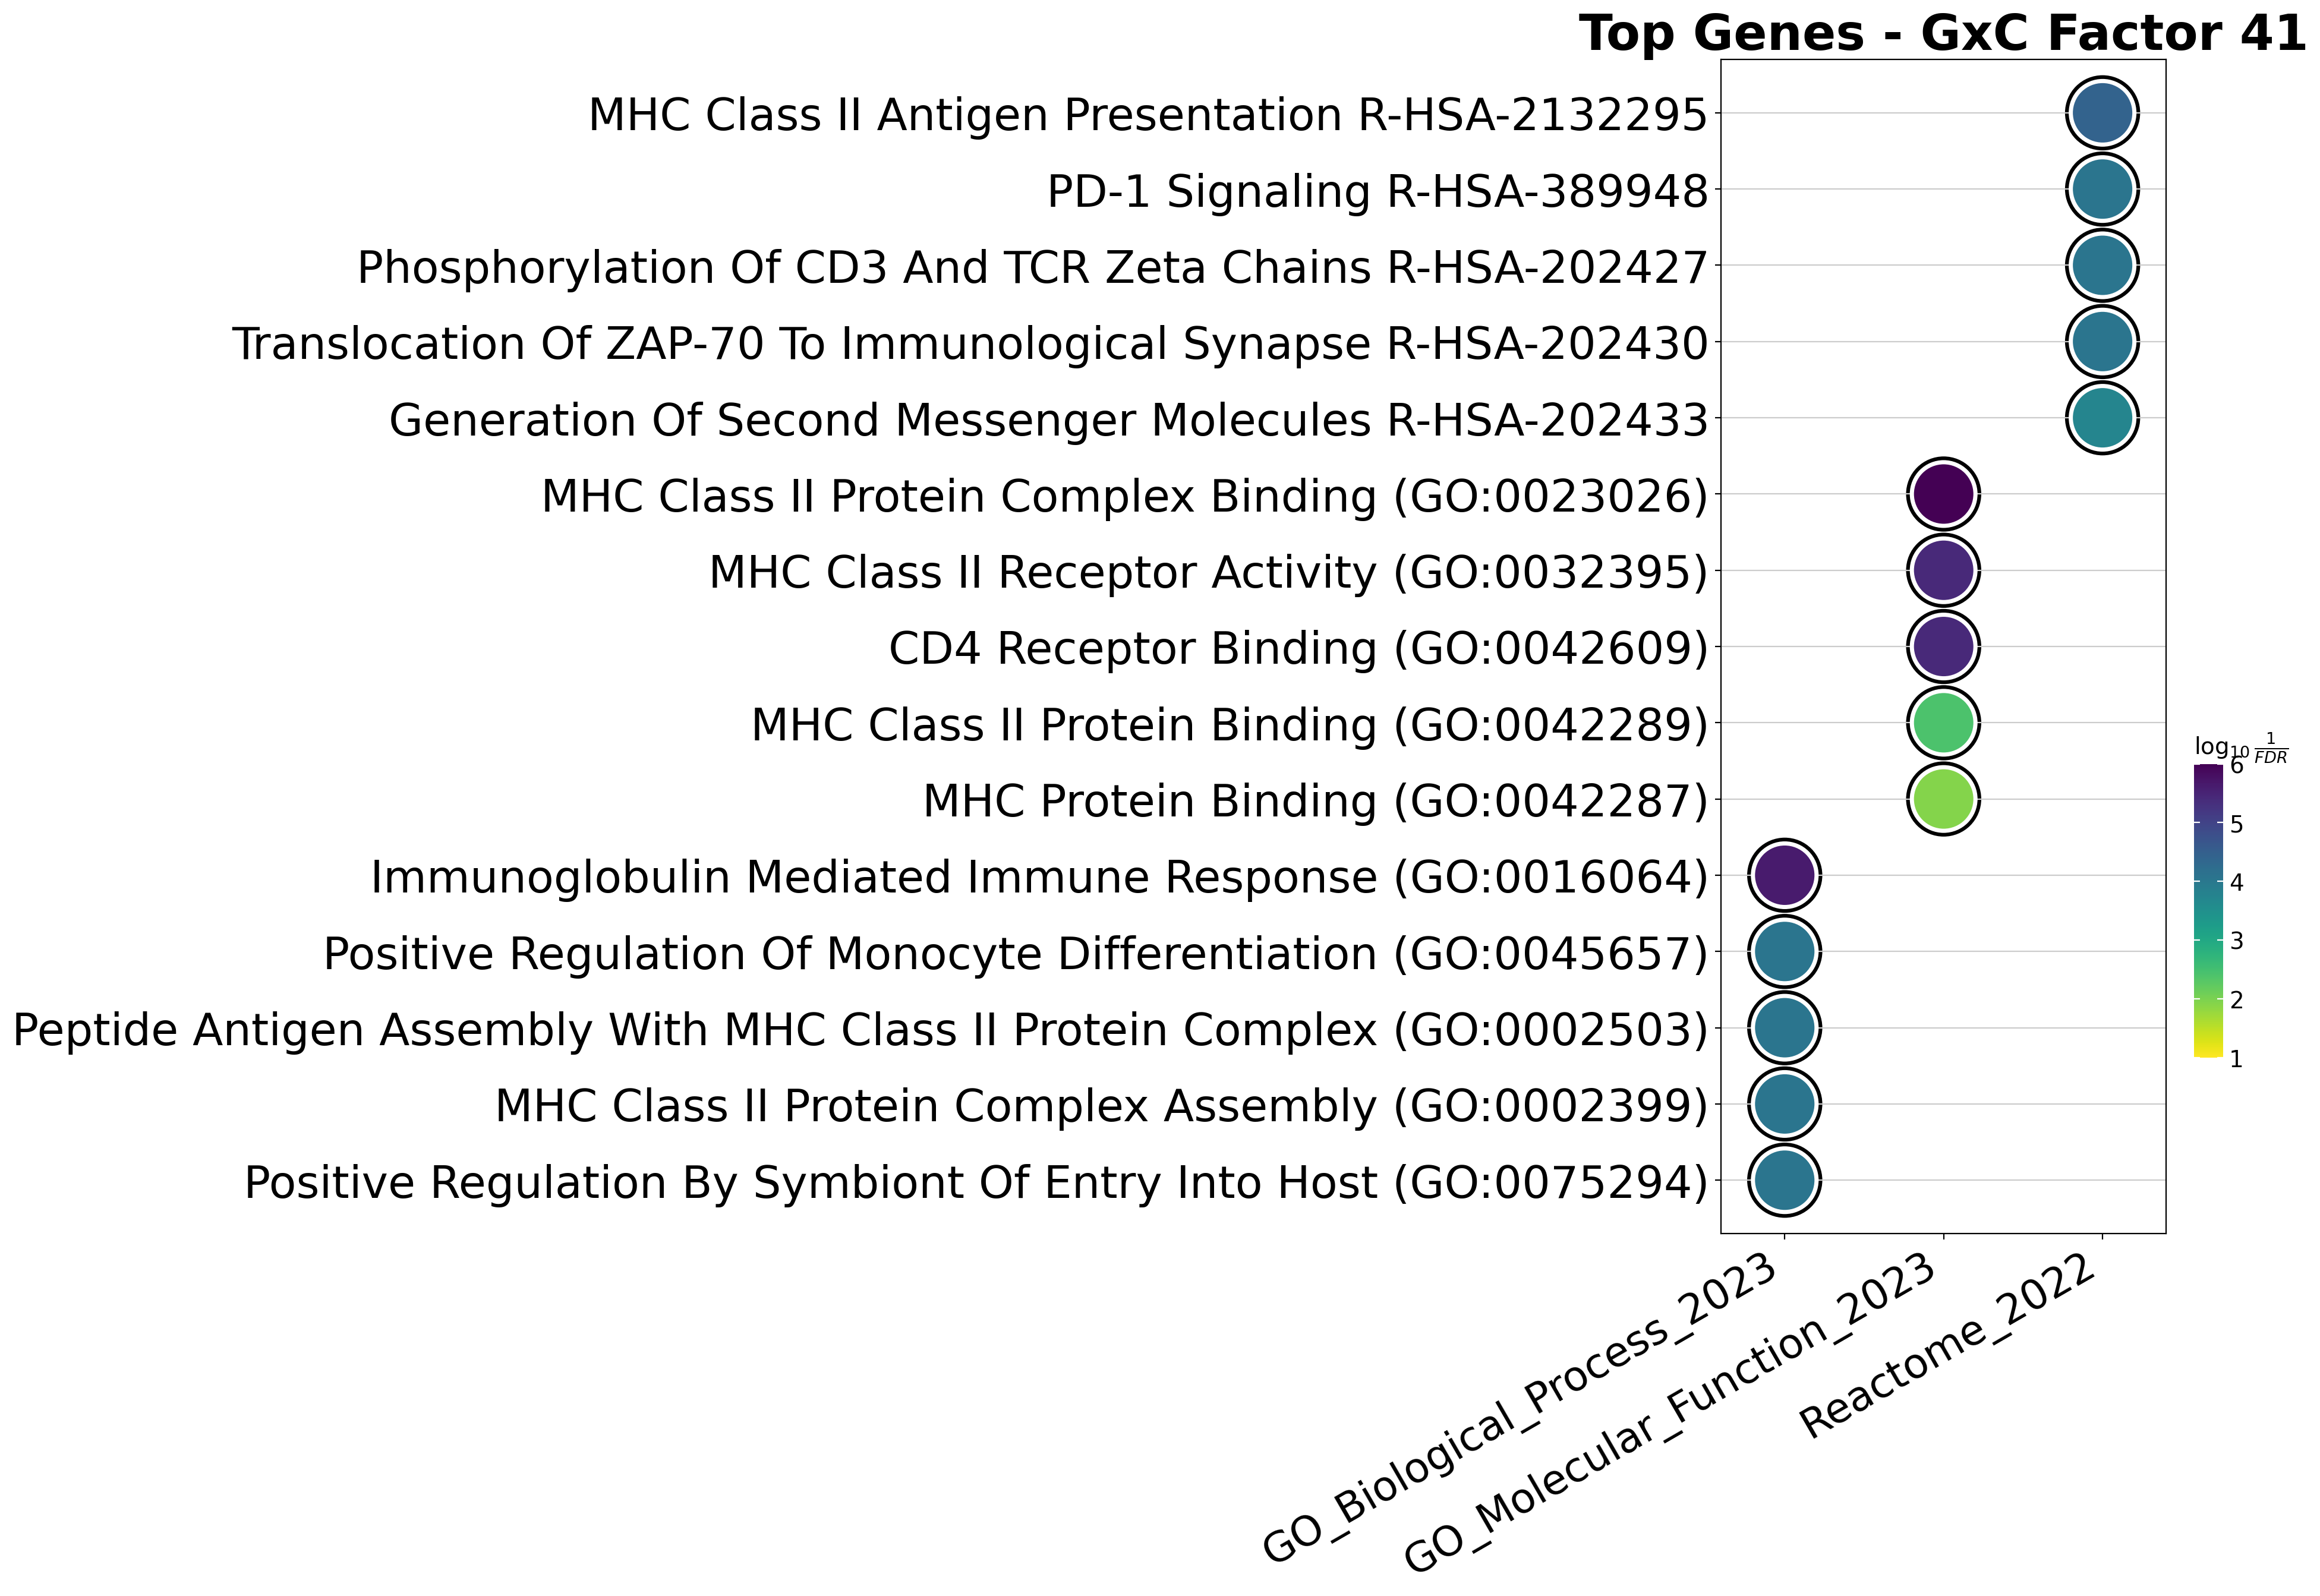

In [1709]:
fig, axs = plt.subplots(figsize=(6,13), constrained_layout=True)
make_gp_dotplot(df=enr_bio_41_sign,
                x="Gene_set",
                y="Term",
                column="Adjusted P-value",
                size=6,
                top_term = 5,
                title = "Top Genes - GxC Factor 41",
                show_ring=True,
                marker="o",
                xticklabels_rot=30,
                ax = axs,
                fig = fig,
                rasterize=True)
axs.set_xlabel("")
plt.savefig(os.path.join(model_results_dir, "Figures", "GSEA_bio_GxC-Factor41_RA-and-Celiac_TopGenes.png"), 
            transparent=True, bbox_inches="tight", dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", "GSEA_bio_GxC-Factor41_RA-and-Celiac_TopGenes.eps"), 
            transparent=True, bbox_inches="tight", dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", "GSEA_bio_GxC-Factor41_RA-and-Celiac_TopGenes.pdf"), 
            transparent=True, bbox_inches="tight", dpi=500)

## Factor and gene loadings correlations

In [183]:
jaccard_prs = {}
jaccard_ngenes = {}
for disease in ["RA", "MS", "CeD", "T1D", "Psoriasis", "UC"]:
    factors_topgenes = {}
    jaccard_factors = []
    total_ngenes = []
    for f in PRS_effects.loc[PRS_effects.SNP_id == disease].Factor.unique():
        f_gxc = f.replace("D", "DxC") 
        factors_topgenes[f_gxc.replace("DxC_Factor", "DxC")] = prs_gene_ct.loc[prs_gene_ct.Factor == f].TopGene.unique().tolist()
    for f1, f2 in itertools.combinations(factors_topgenes.keys(), 2):
        inter = len(set(factors_topgenes[f1]) & set(factors_topgenes[f2]))
        union = len(set(factors_topgenes[f1]) | set(factors_topgenes[f2]))
        sim = inter / union if union > 0 else 0
        jaccard_factors.append(sim)
        total_ngenes.append(union)
    jaccard_prs[disease] = jaccard_factors
    jaccard_ngenes[disease] = total_ngenes

In [184]:
jaccard_ngenes = pd.DataFrame.from_dict(jaccard_ngenes, orient="index").fillna(0)
jaccard_ngenes

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
RA,8,5.0,9.0,6.0,5.0,7.0,13.0,5.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MS,2,3.0,5.0,3.0,5.0,6.0,2.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CeD,8,5.0,5.0,9.0,9.0,6.0,10.0,8.0,5.0,5.0,...,3.0,2.0,3.0,5.0,3.0,4.0,6.0,3.0,5.0,5.0
T1D,3,5.0,2.0,2.0,2.0,4.0,7.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Psoriasis,2,4.0,2.0,3.0,6.0,5.0,2.0,3.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UC,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
jaccard_ngenes = pd.melt(jaccard_ngenes.reset_index(names=["PRS"]), id_vars="PRS", value_name="N_genes")
jaccard_ngenes

,PRS,variable,N_genes
0,RA,0,8.0
1,MS,0,2.0
2,CeD,0,8.0
3,T1D,0,3.0
4,Psoriasis,0,2.0
...,...,...,...
913,MS,152,0.0
914,CeD,152,5.0
915,T1D,152,0.0
916,Psoriasis,152,0.0


In [186]:
jaccard_prs = pd.melt(pd.DataFrame.from_dict(jaccard_prs, orient="index").reset_index(names=["PRS"]), id_vars="PRS", value_name="Jaccard similarity")
jaccard_prs

,PRS,variable,Jaccard similarity
0,RA,0,0.0
1,MS,0,0.0
2,CeD,0,0.0
3,T1D,0,0.0
4,Psoriasis,0,0.0
...,...,...,...
913,MS,152,NaN
914,CeD,152,0.2
915,T1D,152,NaN
916,Psoriasis,152,NaN


In [187]:
jaccard_prs = jaccard_prs.merge(jaccard_ngenes.N_genes, right_index=True, left_index=True)
jaccard_prs

,PRS,variable,Jaccard similarity,N_genes
0,RA,0,0.0,8.0
1,MS,0,0.0,2.0
2,CeD,0,0.0,8.0
3,T1D,0,0.0,3.0
4,Psoriasis,0,0.0,2.0
...,...,...,...,...
913,MS,152,NaN,0.0
914,CeD,152,0.2,5.0
915,T1D,152,NaN,0.0
916,Psoriasis,152,NaN,0.0


In [193]:
mean_similarity = jaccard_prs.groupby("PRS", observed=True).apply(lambda x: x["Jaccard similarity"].mean(), include_groups=False).to_dict()

In [194]:
jaccard_prs.PRS = pd.Categorical(jaccard_prs.PRS, categories = ["RA", "MS", "CeD", "T1D", "Psoriasis", "UC"], ordered=True)

In [195]:
codes_PRS_dict = dict(zip(jaccard_prs.PRS.cat.codes.astype(str).tolist(), jaccard_prs.PRS))
codes_PRS_dict

{'0': 'RA', '1': 'MS', '2': 'CeD', '3': 'T1D', '4': 'Psoriasis', '5': 'UC'}

/tmp/ipykernel_1797050/3319071408.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


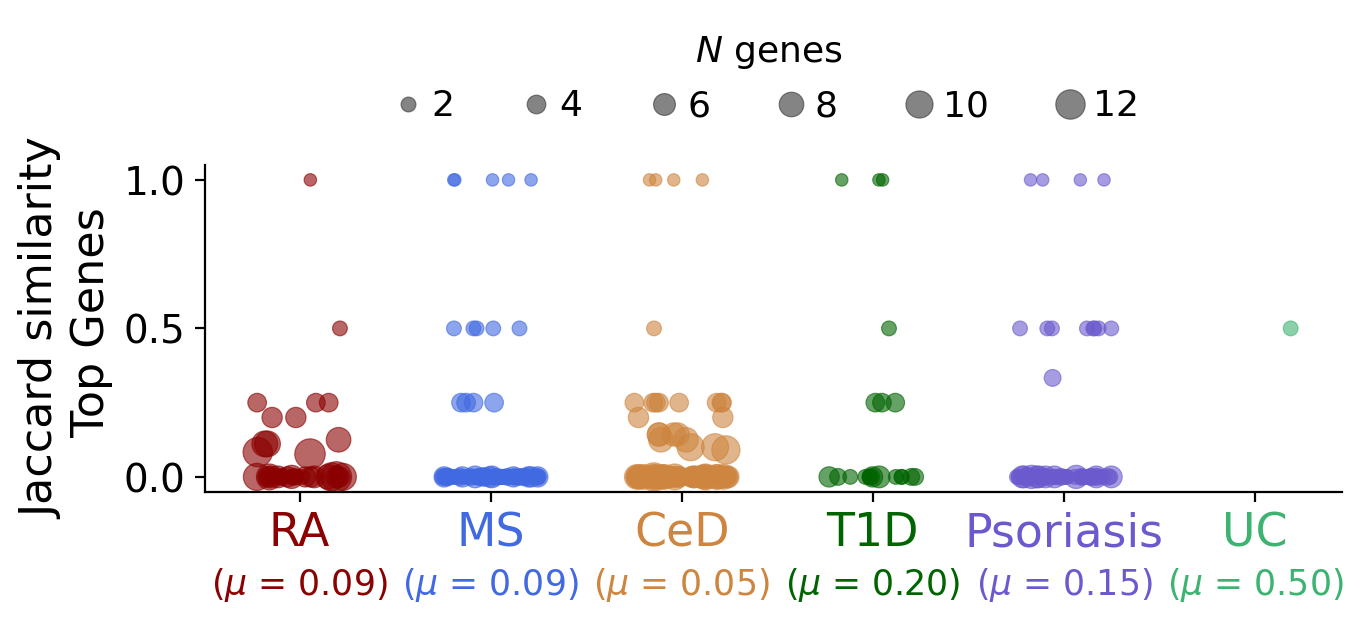

In [164]:
# make a numerical column and add some jitter
jaccard_prs["PRS_jittered"] = jaccard_prs.PRS.cat.codes + np.random.uniform(-0.25, 0.25, jaccard_prs.shape[0])

fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(6.7,3), constrained_layout=True)

sns.scatterplot(x="PRS_jittered", y="Jaccard similarity", data=jaccard_prs.dropna(axis=0, subset=["Jaccard similarity"]),
                hue="PRS", size="N_genes", sizes=(20,120), size_norm=(1.0, jaccard_prs.N_genes.max()), palette=PRS_colors_dark, ax=axs, 
                alpha=0.6, edgecolor="face")

axs.set_ylabel("Jaccard similarity\n Top Genes", fontsize=16)
# tick_interval = np.abs(axs.get_yticks().max() - axs.get_yticks().min())/4
axs.set_yticks(np.arange(0, 1.5, 0.5), np.arange(0, 1.5, 0.5), fontsize=14)
axs.set_xlabel("")

axs.spines["right"].set_visible(False)
axs.spines["top"].set_visible(False)

for label in axs.get_xticklabels():
    DC = label.get_text()
    if DC in codes_PRS_dict.keys():
        DL = codes_PRS_dict[DC]
        label.set_color(PRS_colors_dark[DL])

new_xlabels = [codes_PRS_dict[label.get_text()] 
               if label.get_text() in codes_PRS_dict.keys()
               else label.get_text() 
               for label in axs.get_xticklabels()]
axs.set_xticklabels(new_xlabels, fontdict={"fontsize":16.5, }) # "fontweight":"bold"

xticks = axs.get_xticks()

for x, label in zip(xticks, new_xlabels):
    if label in mean_similarity.keys():
        axs.annotate(
            text=f"($\mu$ = {mean_similarity[label]:.2f})",
            xy=(x, 0),
            xytext=(x, -0.3), 
            ha="center", 
            va="top",
            color=PRS_colors_dark[label],
            fontsize=12.5,
            annotation_clip=False  # draws outside the axes
        )

legend_handles, legend_labels = (axs.get_legend_handles_labels()[0][8:], axs.get_legend_handles_labels()[1][8:])

legend_labels = [str(int(la)) for la in np.ceil([float(la) for la in legend_labels])]

axs.legend(title="$N$ genes", labels=legend_labels, handles=legend_handles, frameon=False, loc="best", title_fontsize=13, fontsize=13, 
           ncol=len(legend_labels), bbox_to_anchor=(0.85, 1.5))

plt.savefig(os.path.join(model_results_dir, "Figures", "Stripplots_Jaccard-similarity_GxC-loadings-TopGenes_PRS-associated-factors_dark-colors_dot-size-N-genes.png"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Stripplots_Jaccard-similarity_GxC-loadings-TopGenes_PRS-associated-factors_dark-colors_dot-size-N-genes.eps"), 
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Stripplots_Jaccard-similarity_GxC-loadings-TopGenes_PRS-associated-factors_dark-colors_dot-size-N-genes.pdf"), 
            transparent=True, dpi=500, bbox_inches="tight")

In [196]:
PRS_genes = outtable.groupby("PRS").apply(lambda x: x.TopGenes.unique(), include_groups=False)
PRS_genes

PRS
CeD          [CD52; HLA-DPA1; HLA-DRA; HLA-DPB1; PSMB9; RAR...
MS           [HLA-A, MT-CO2; HLA-A; IGJ; MT-ND4, MT-CO1; MT...
Psoriasis    [HLA-B, HLA-B; HLA-C; ARPC3, AIF1, HLA-DRB5, C...
RA           [DUSP2; HLA-DQA1; TCF4; JUN; YBX3; RPLP1; CD79...
T1D          [HLA-DQB1, HLA-DPB1; HLA-DRB1; RPS29; HLA-DQB1...
UC                              [HLA-DQA2; HLA-DRB5, HLA-DQA2]
dtype: object

In [197]:
PRS_genes = PRS_genes.apply(lambda x: "; ".join(x))
PRS_genes = PRS_genes.apply(lambda x: x.split("; "))
PRS_genes = PRS_genes.apply(lambda x: set(x))
PRS_genes

PRS
CeD          {WARS, ZFP36, RPL35, CD74, RPL14, GZMK, HLA-DQ...
MS           {GZMK, HLA-DQA1, HLA-DRB5, HLA-DQB1, MT-ND4, M...
Psoriasis    {ARPC3, ZFP36, RPL38, HLA-C, CYBA, CD37, UBB, ...
RA           {RPL35, CD74, RPL14, GZMK, HLA-DQA1, HLA-DRB5,...
T1D          {CD79A, HLA-DQB1, HLA-DPB1, HLA-DQA2, RPLP1, H...
UC                                        {HLA-DRB5, HLA-DQA2}
dtype: object

In [198]:
jaccard_between_prs = pd.DataFrame(index=PRS_genes.index, columns=PRS_genes.index)
for p1, p2 in itertools.combinations(PRS_genes.index, 2):
    inter = len(PRS_genes[p1] & PRS_genes[p2])
    union = len(PRS_genes[p1] | PRS_genes[p2])
    sim = inter / union if union > 0 else 0
    jaccard_between_prs.loc[p1, p2] = sim
    jaccard_between_prs.loc[p2, p1] = sim

jaccard_between_prs

PRS,CeD,MS,Psoriasis,RA,T1D,UC
PRS,,,,,,
CeD,NaN,0.384615,0.133333,0.414634,0.285714,0.057143
MS,0.384615,NaN,0.129032,0.272727,0.526316,0.105263
Psoriasis,0.133333,0.129032,NaN,0.054054,0.083333,0.058824
RA,0.414634,0.272727,0.054054,NaN,0.32,0.086957
T1D,0.285714,0.526316,0.083333,0.32,NaN,0.2
UC,0.057143,0.105263,0.058824,0.086957,0.2,NaN


In [199]:
jaccard_between_prs = jaccard_between_prs.fillna(1)
jaccard_between_prs

/tmp/ipykernel_1797050/935846824.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


PRS,CeD,MS,Psoriasis,RA,T1D,UC
PRS,,,,,,
CeD,1.000000,0.384615,0.133333,0.414634,0.285714,0.057143
MS,0.384615,1.000000,0.129032,0.272727,0.526316,0.105263
Psoriasis,0.133333,0.129032,1.000000,0.054054,0.083333,0.058824
RA,0.414634,0.272727,0.054054,1.000000,0.320000,0.086957
T1D,0.285714,0.526316,0.083333,0.320000,1.000000,0.200000
UC,0.057143,0.105263,0.058824,0.086957,0.200000,1.000000


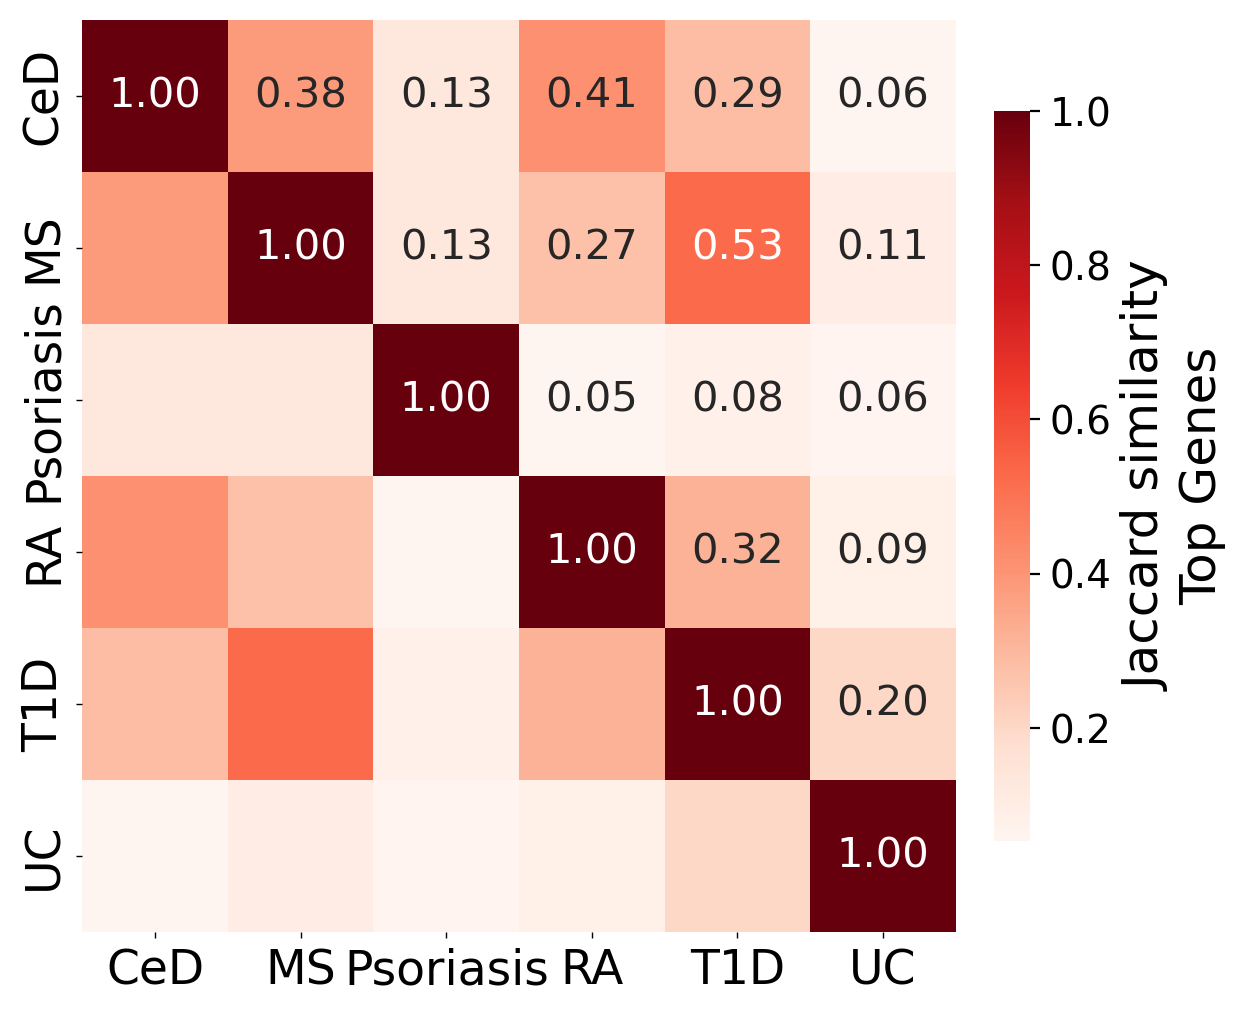

In [201]:
hmap = sns.heatmap(jaccard_between_prs, 
                   cmap="Reds", 
                   vmin=jaccard_between_prs.min().min(),
                   vmax=jaccard_between_prs.max().max(),
                   annot=False,
                   cbar_kws={"label":"Jaccard similarity\nTop Genes", "anchor":(-0.13,0.5), "shrink":0.8},
                   rasterized = True)

hmap.set_xlabel("")
hmap.set_ylabel("")
cbar = hmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(18) 

# Add (only) annotations to the upper triangle
mask = np.tril(np.ones_like(jaccard_between_prs, dtype=bool), k=-1)

hmap = sns.heatmap(jaccard_between_prs, 
                   cmap="Reds", 
                   vmin=jaccard_between_prs.min().min(),
                   vmax=jaccard_between_prs.max().max(),
                   mask=mask,
                   annot=True,
                   fmt=".2f", 
                   annot_kws={"size":15},
                   cbar=False,
                   alpha=0,
                   rasterized = True)
hmap.set_xlabel("")
hmap.set_ylabel("")

plt.tick_params(axis="both", which="both", labelsize=17, length=2, width=0.5)

plt.savefig(os.path.join(model_results_dir, "Figures", "Jaccard-similarity-TopGenes_between-PRS.png"), 
            dpi=400, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Jaccard-similarity-TopGenes_between-PRS.pdf"), 
            dpi=400, transparent=True, bbox_inches="tight")

## UpSet plot

In [202]:
from upsetplot import UpSet, from_contents

In [206]:
# prs_gene_ct.PRS.replace({"Multiple_sclerosis": "MS", "Celiac":"CLD"}, inplace=True)
PRS_genes = prs_gene_ct.groupby("PRS", observed=True).apply(lambda x: [g for g in x.TopGene.unique().tolist() if g is not None], include_groups=False).to_dict()
PRS_genes = from_contents(PRS_genes)

/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

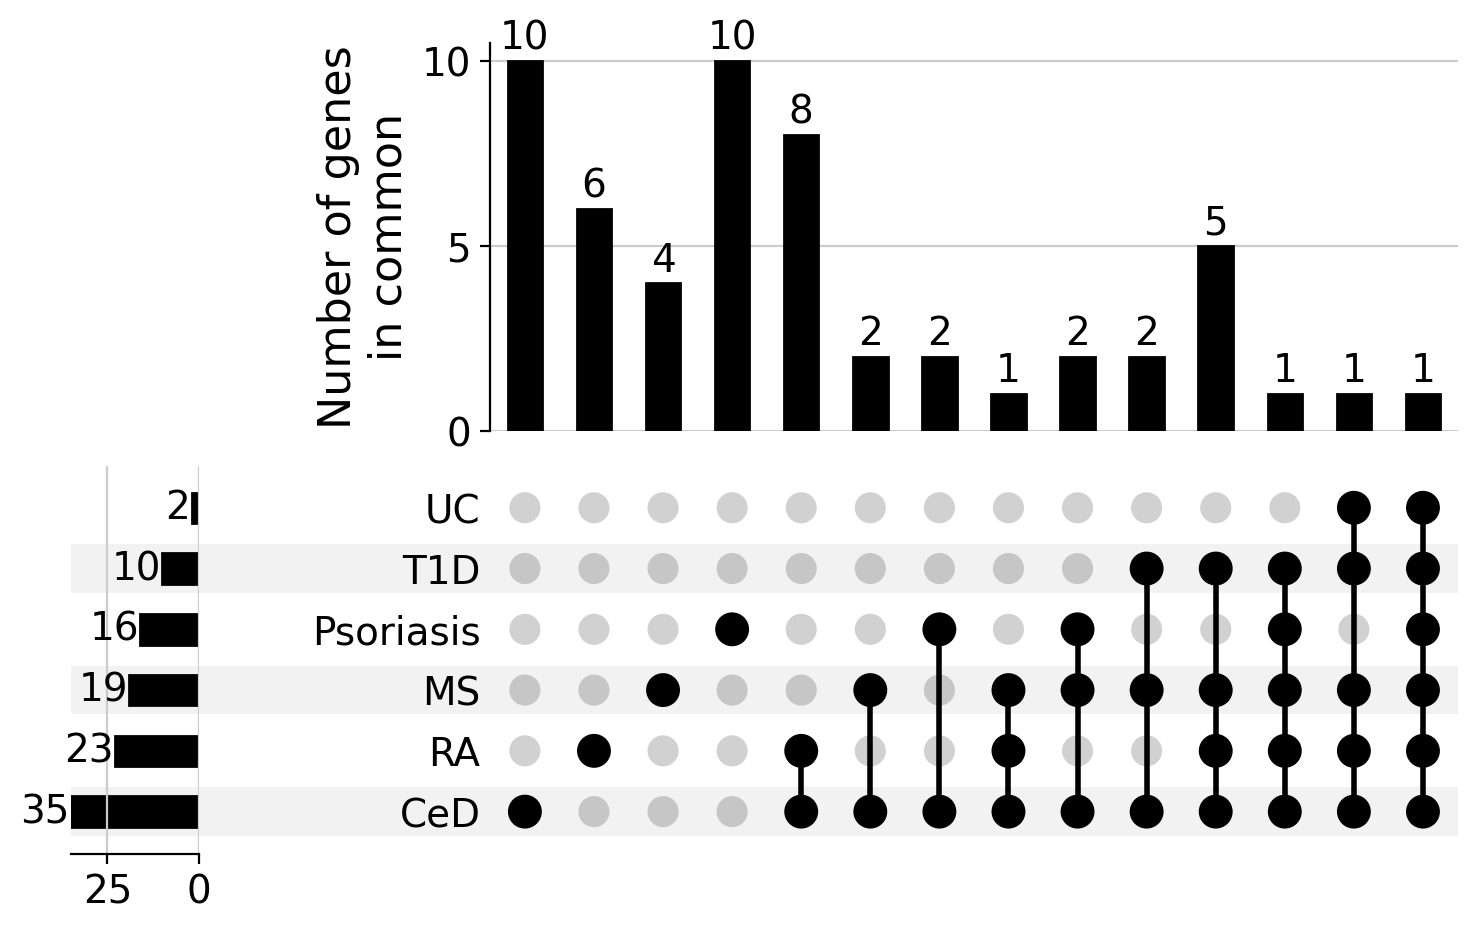

In [207]:
upset_plot = UpSet(PRS_genes, subset_size="count", show_counts=True).plot()
upset_plot["intersections"].set_ylabel(textwrap.fill("Number of genes in common", width=15), fontsize=16)
# plt.title("Overlap between genes\n", fontsize=16)
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_Gene-overlap-for-PRS.png"),
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_Gene-overlap-for-PRS.pdf"),
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_Gene-overlap-for-PRS.eps"),
            transparent=True, dpi=500, bbox_inches="tight")

In [295]:
upset_plot

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Number of\nassociated\nfactors in\ncommon'>}

/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/data/danai/miniforge3/envs/LIVI

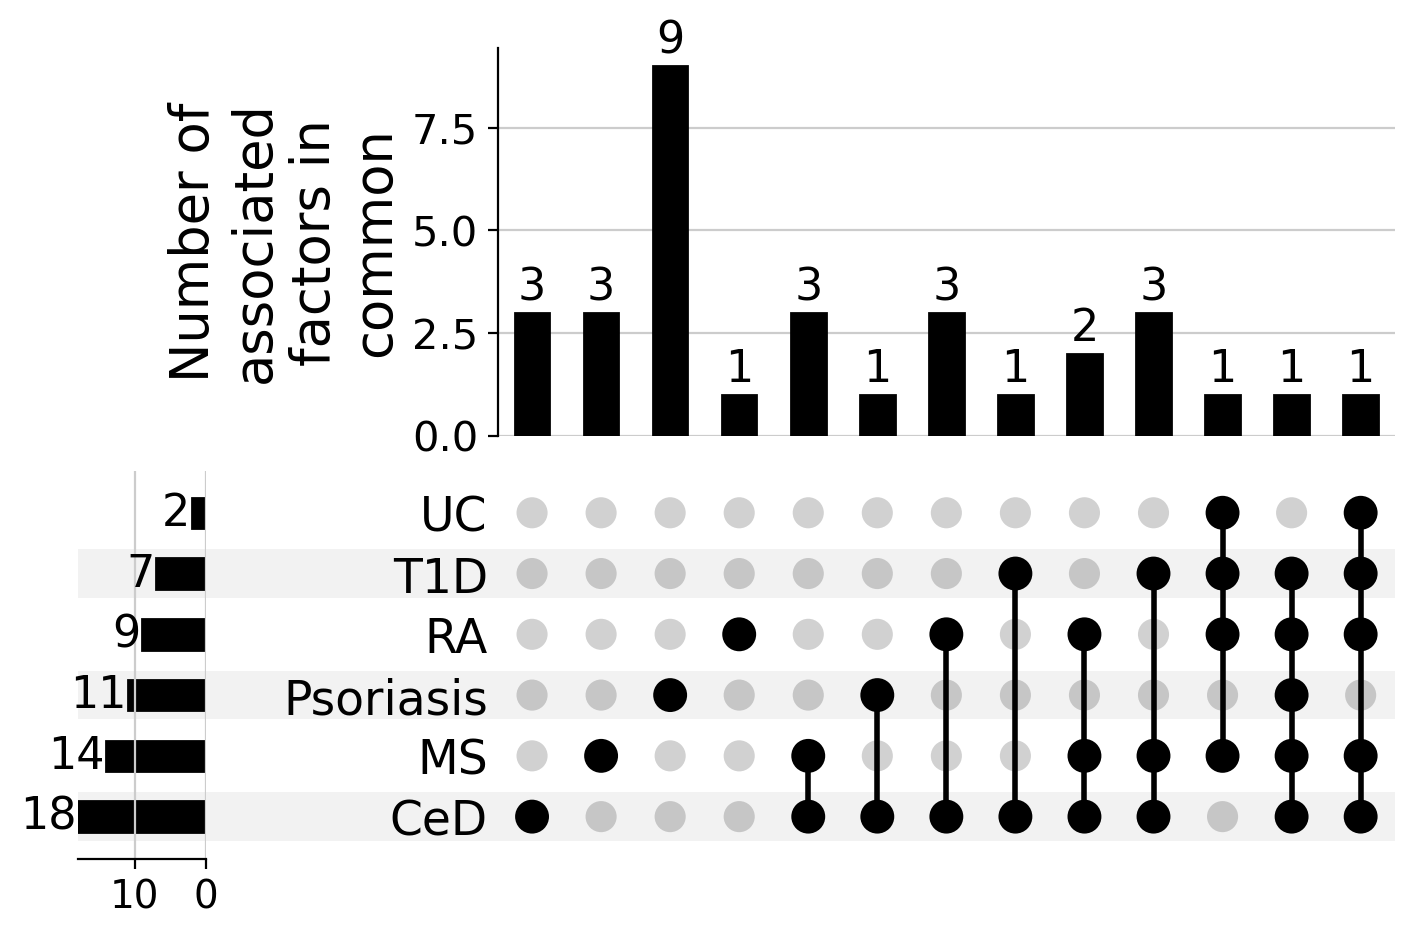

In [208]:
PRS_factors = prs_gene_ct.groupby("PRS", observed=True).apply(lambda x: x.Factor.unique().tolist(), include_groups=False).to_dict()

PRS_factors = from_contents(PRS_factors)

upset_plot = UpSet(PRS_factors, subset_size="count", show_counts=True).plot()
upset_plot["intersections"].set_ylabel(textwrap.fill("Number of associated factors in common\n", width=15), fontsize=19)
upset_plot["intersections"].tick_params(labelsize=15)
upset_plot["matrix"].tick_params(labelsize=17)
for txt in upset_plot["intersections"].texts:
    txt.set_fontsize(16)
for txt in upset_plot["totals"].texts:
    txt.set_fontsize(16)

# plt.title("Overlap between associated factors\n", fontsize=16)
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_U-overlap-for-PRS.png"),
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_U-overlap-for-PRS.eps"),
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "UpSet_plot_U-overlap-for-PRS.pdf"),
            transparent=True, dpi=500, bbox_inches="tight")